# This notebook recreates plots in the results section of the paper

In [18]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import emcee
import corner
import scipy.stats as sps
from tqdm import trange
from isochrones.mist import MIST_Isochrone
mist = MIST_Isochrone()

from stardate.lhf import convective_overturn_time

plotpar = {'axes.labelsize': 20,
           'font.size': 25,
           'legend.fontsize': 25,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Produce plots for the simulated data.

Load the simulated data set.

In [25]:
df = pd.read_csv("data/simulated_data.csv")

Text(0, 0.5, '$\\log(g)$')

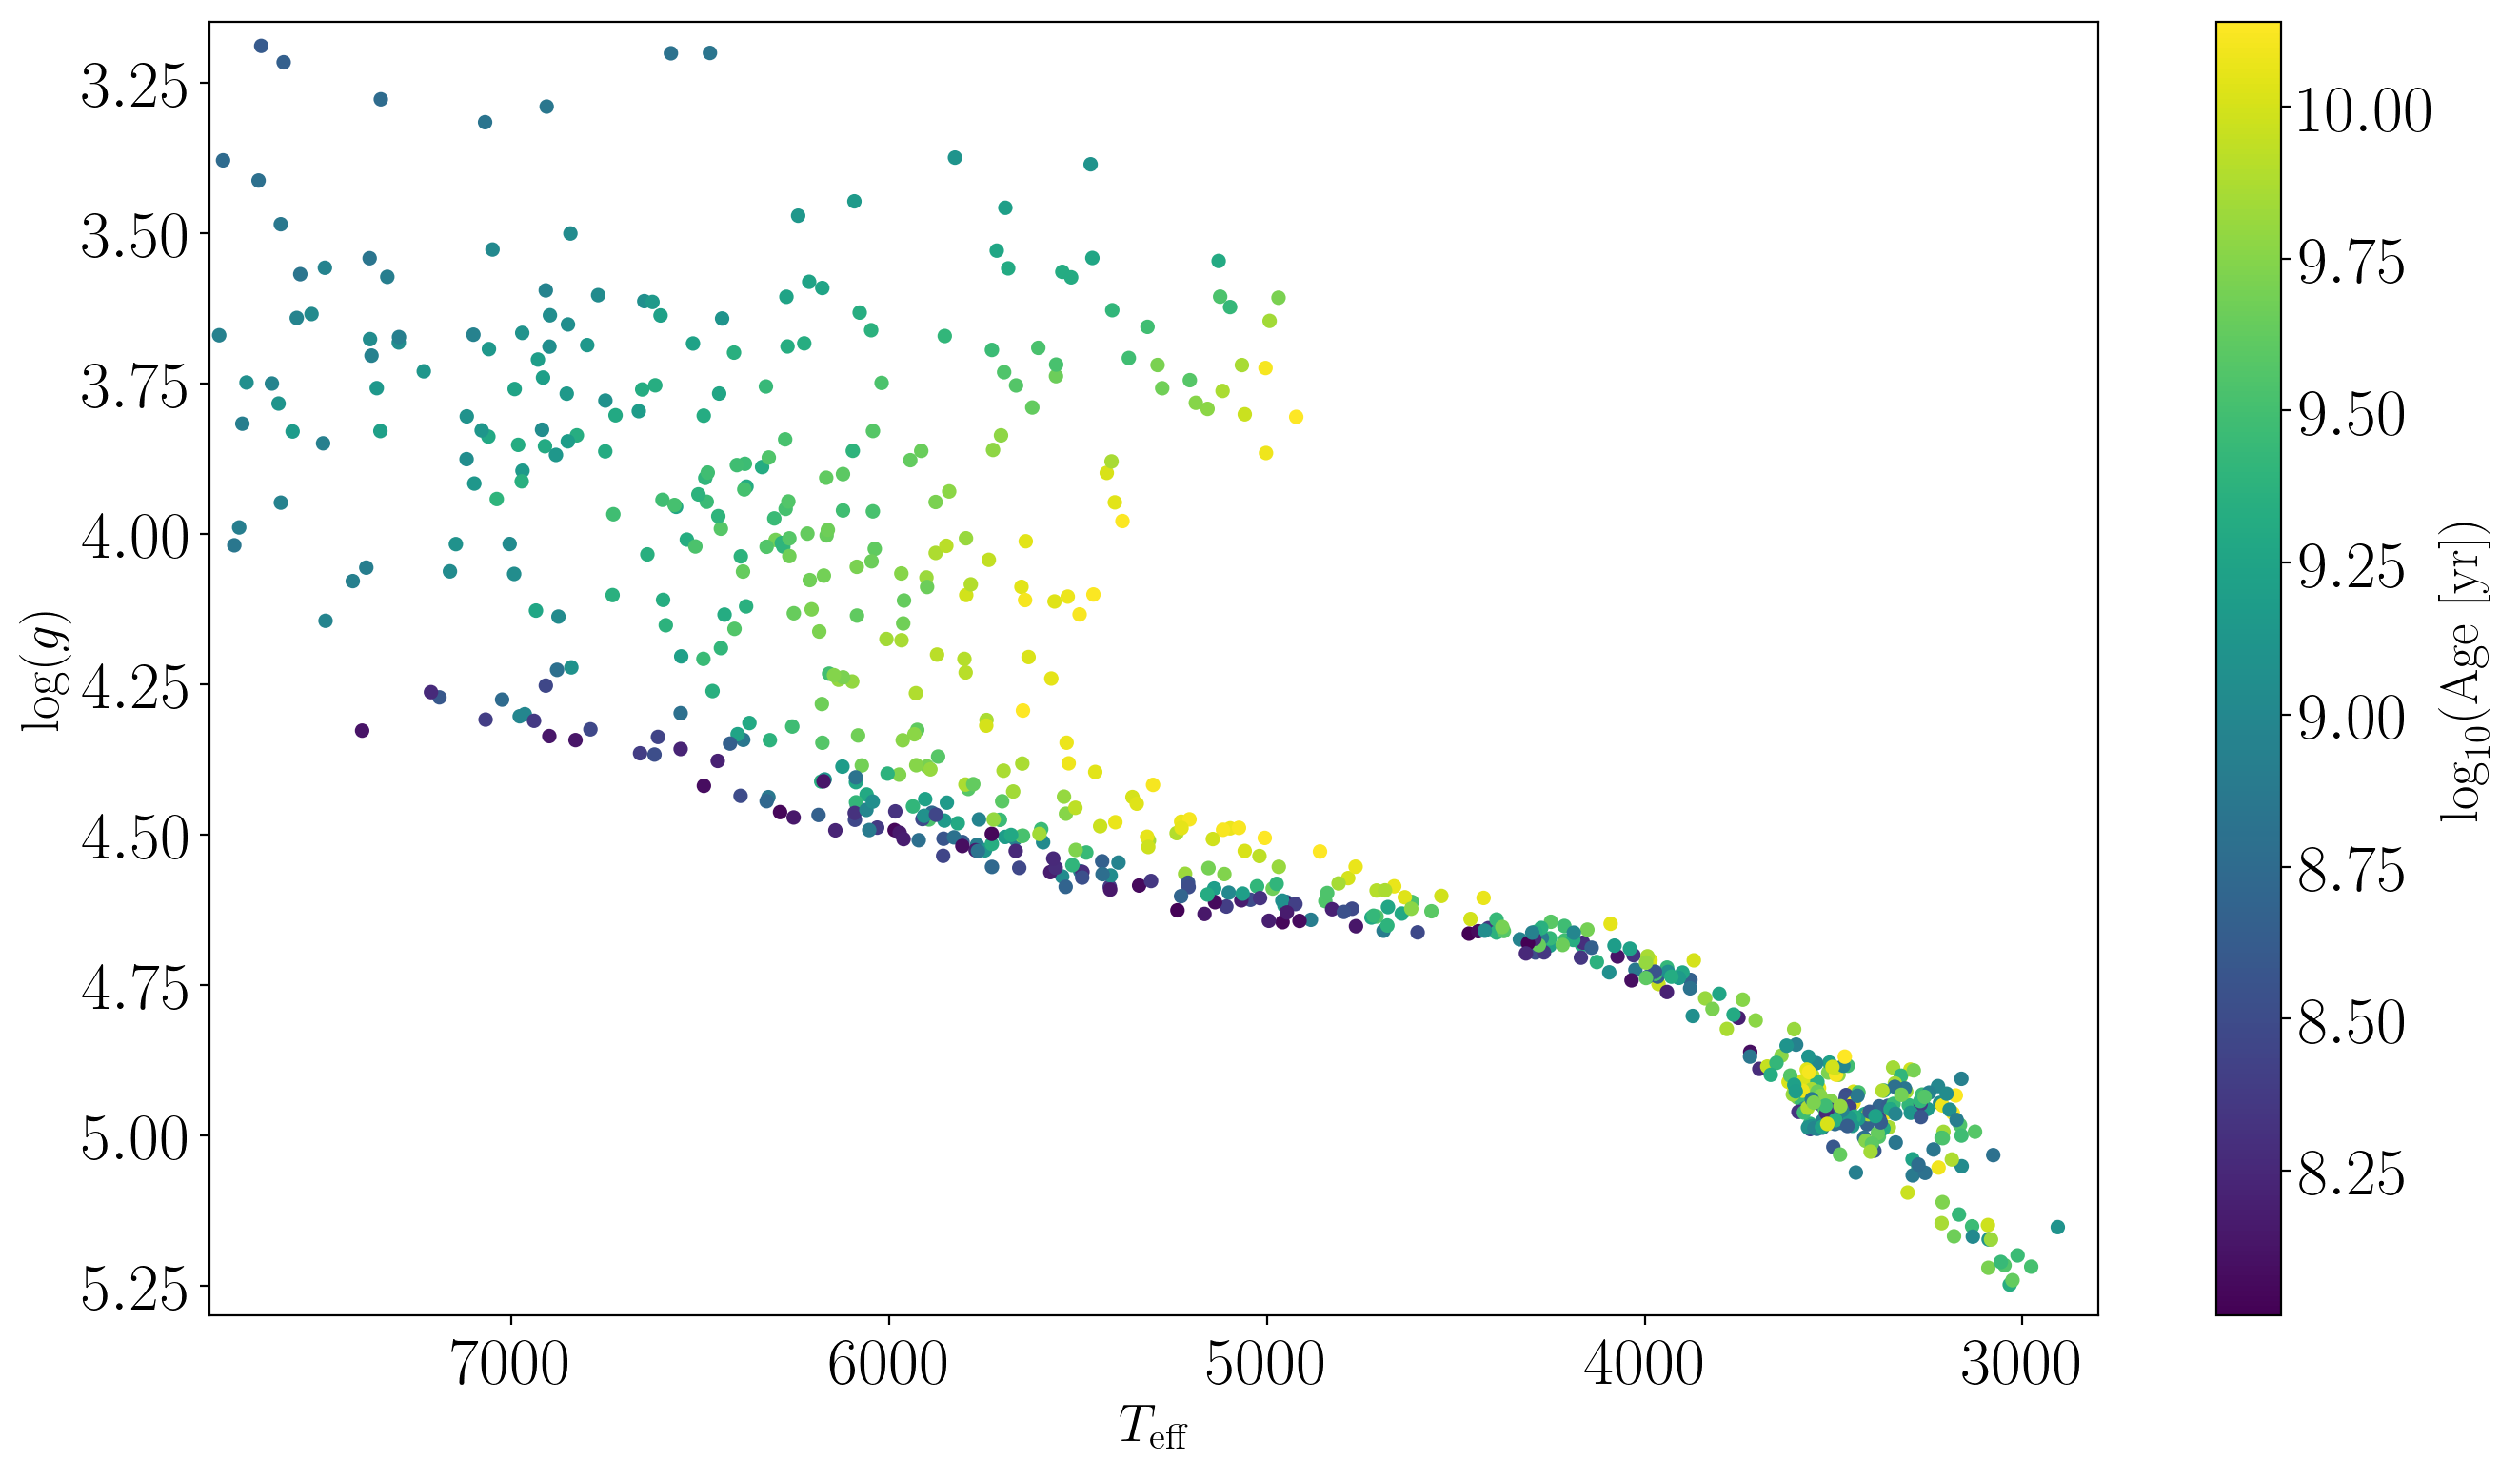

In [20]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff, df.logg, c=df.age, s=20)
plt.colorbar(label="$\log_{10}(\mathrm{Age~[yr]})$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
# plt.xlim(5500, 3000)
# plt.ylim(5, 4.5)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

Plot a corner plot for the first star.

[301.7439338714983, 8.396184467714647, -0.09531772650563762, 6.516157519592511, 0.05719958782835927]


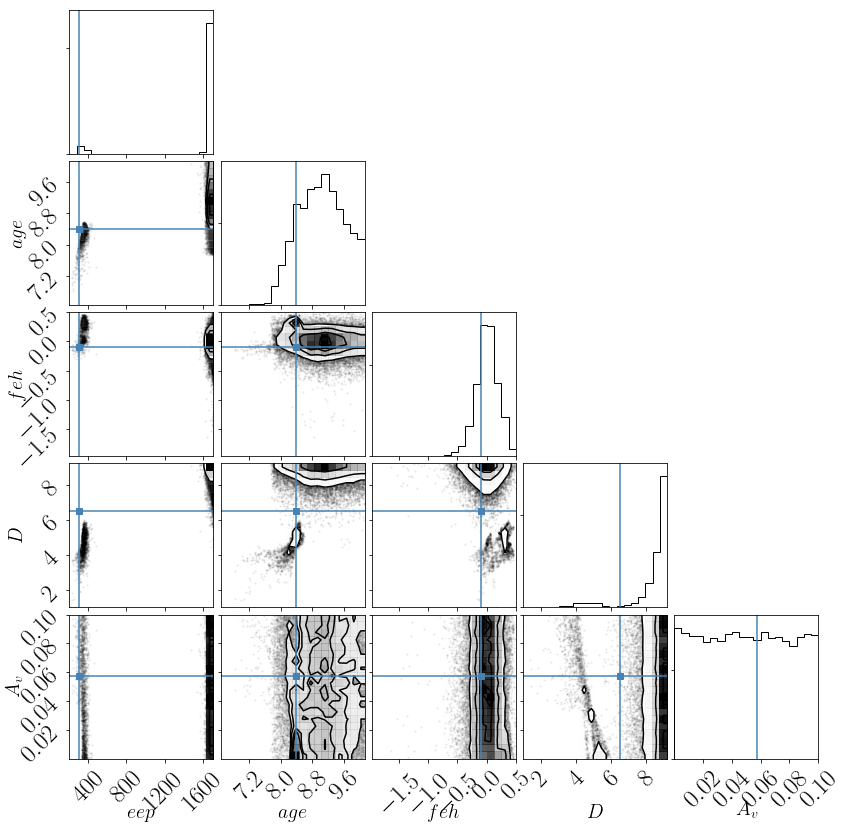

In [28]:
i = 0

fname = "{0}_stardate.h5".format(str(i).zfill(4))
reader = emcee.backends.HDFBackend(fname, read_only=True)
samples = reader.get_chain()
nsteps, nwalkers, ndim = np.shape(samples)
    
burnin = 100
samps = np.reshape(samples[burnin:, :, :], (nwalkers*(nsteps - burnin), ndim))
truths = [df.eep.values[i], df.age.values[i], df.feh.values[i], 
          np.log(1./(df.parallax[i]*1e-3)), df.Av.values[i]]
corner.corner(samps, truths=truths, labels=["$eep$", "$age$", "$feh$", "$D$", "$A_v$"]);
print(truths)

And plot the trace.

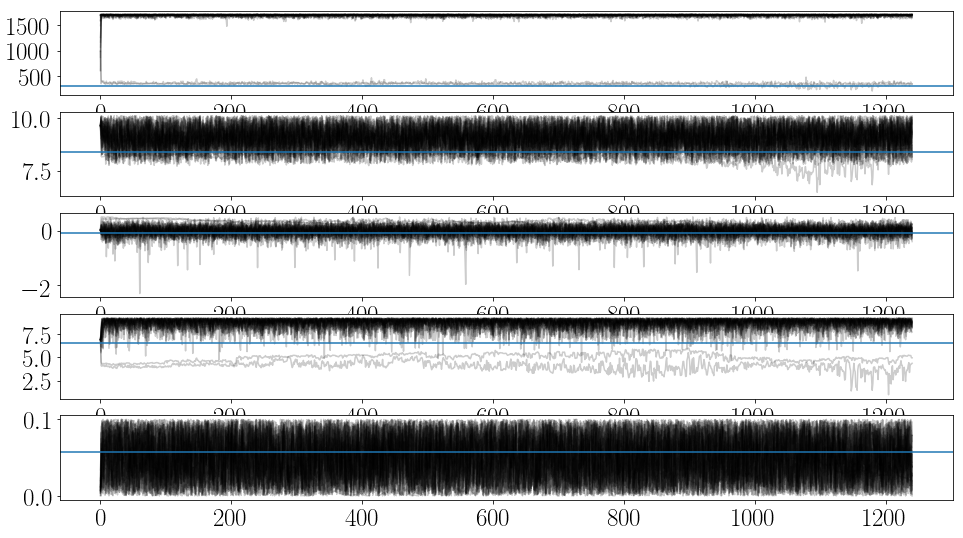

In [29]:
truths = [df.eep[i], df.age[i], df.feh[i], np.log(df.d_kpc[i]*1e3), df.Av[i]]

nsteps, nwalkers, ndim = np.shape(samples)
flat = np.reshape(samples, (nsteps*nwalkers, ndim))
plt.figure(figsize=(16, 9))
for j in range(5):
    plt.subplot(5, 1, j+1)
    plt.plot(samples[:, :, j], color="k", alpha=.2)
    plt.axhline(truths[j])

Now plot all the results.

In [30]:
N = 900

meds, stds, age_samps, resids, errp, errm = [], [], [], [], [], []
eeps, eep_errp, eep_errm, inds = [], [], [], []

burnin = 1

for i in range(N):
    try:
        fname = "{}_stardate.h5".format(str(i).zfill(4))
        reader = emcee.backends.HDFBackend(fname)
        samples = reader.get_chain()
        nsteps, nwalkers, ndim = np.shape(samples)
        samps = np.reshape(samples, (nsteps*nwalkers, ndim))

        lin_samps = (10**samps[:, 1])*1e-9
        age_samps.append(lin_samps)
#         resids.append(list(np.array(age_samps[i]) - true_age_gyr[i]))
        meds.append(np.median(lin_samps))
        stds.append(np.std(lin_samps))
        upper = np.percentile(lin_samps, 84)
        lower = np.percentile(lin_samps, 16)
        errp.append(upper-np.median(lin_samps))
        errm.append(np.median(lin_samps)-lower)
    
        eep_samps = samps[:, 0]
        eeps.append(np.median(eep_samps))
        upper = np.percentile(lin_samps, 84)
        lower = np.percentile(lin_samps, 16)
        eep_errp.append(upper-np.median(lin_samps))
        eep_errm.append(np.median(lin_samps)-lower)
        
        inds.append(i)
        
    except AttributeError:
        pass
    
meds, stds, errp, errm = np.array(meds), np.array(stds), np.array(errp), np.array(errm)
print(len(eeps))

30


[  0   1   2   9  18  19  27  36  45  54  63  72  90  99 100 108 117 126
 135 144 145 153 162 171 180 189 198 207]
[]
[]


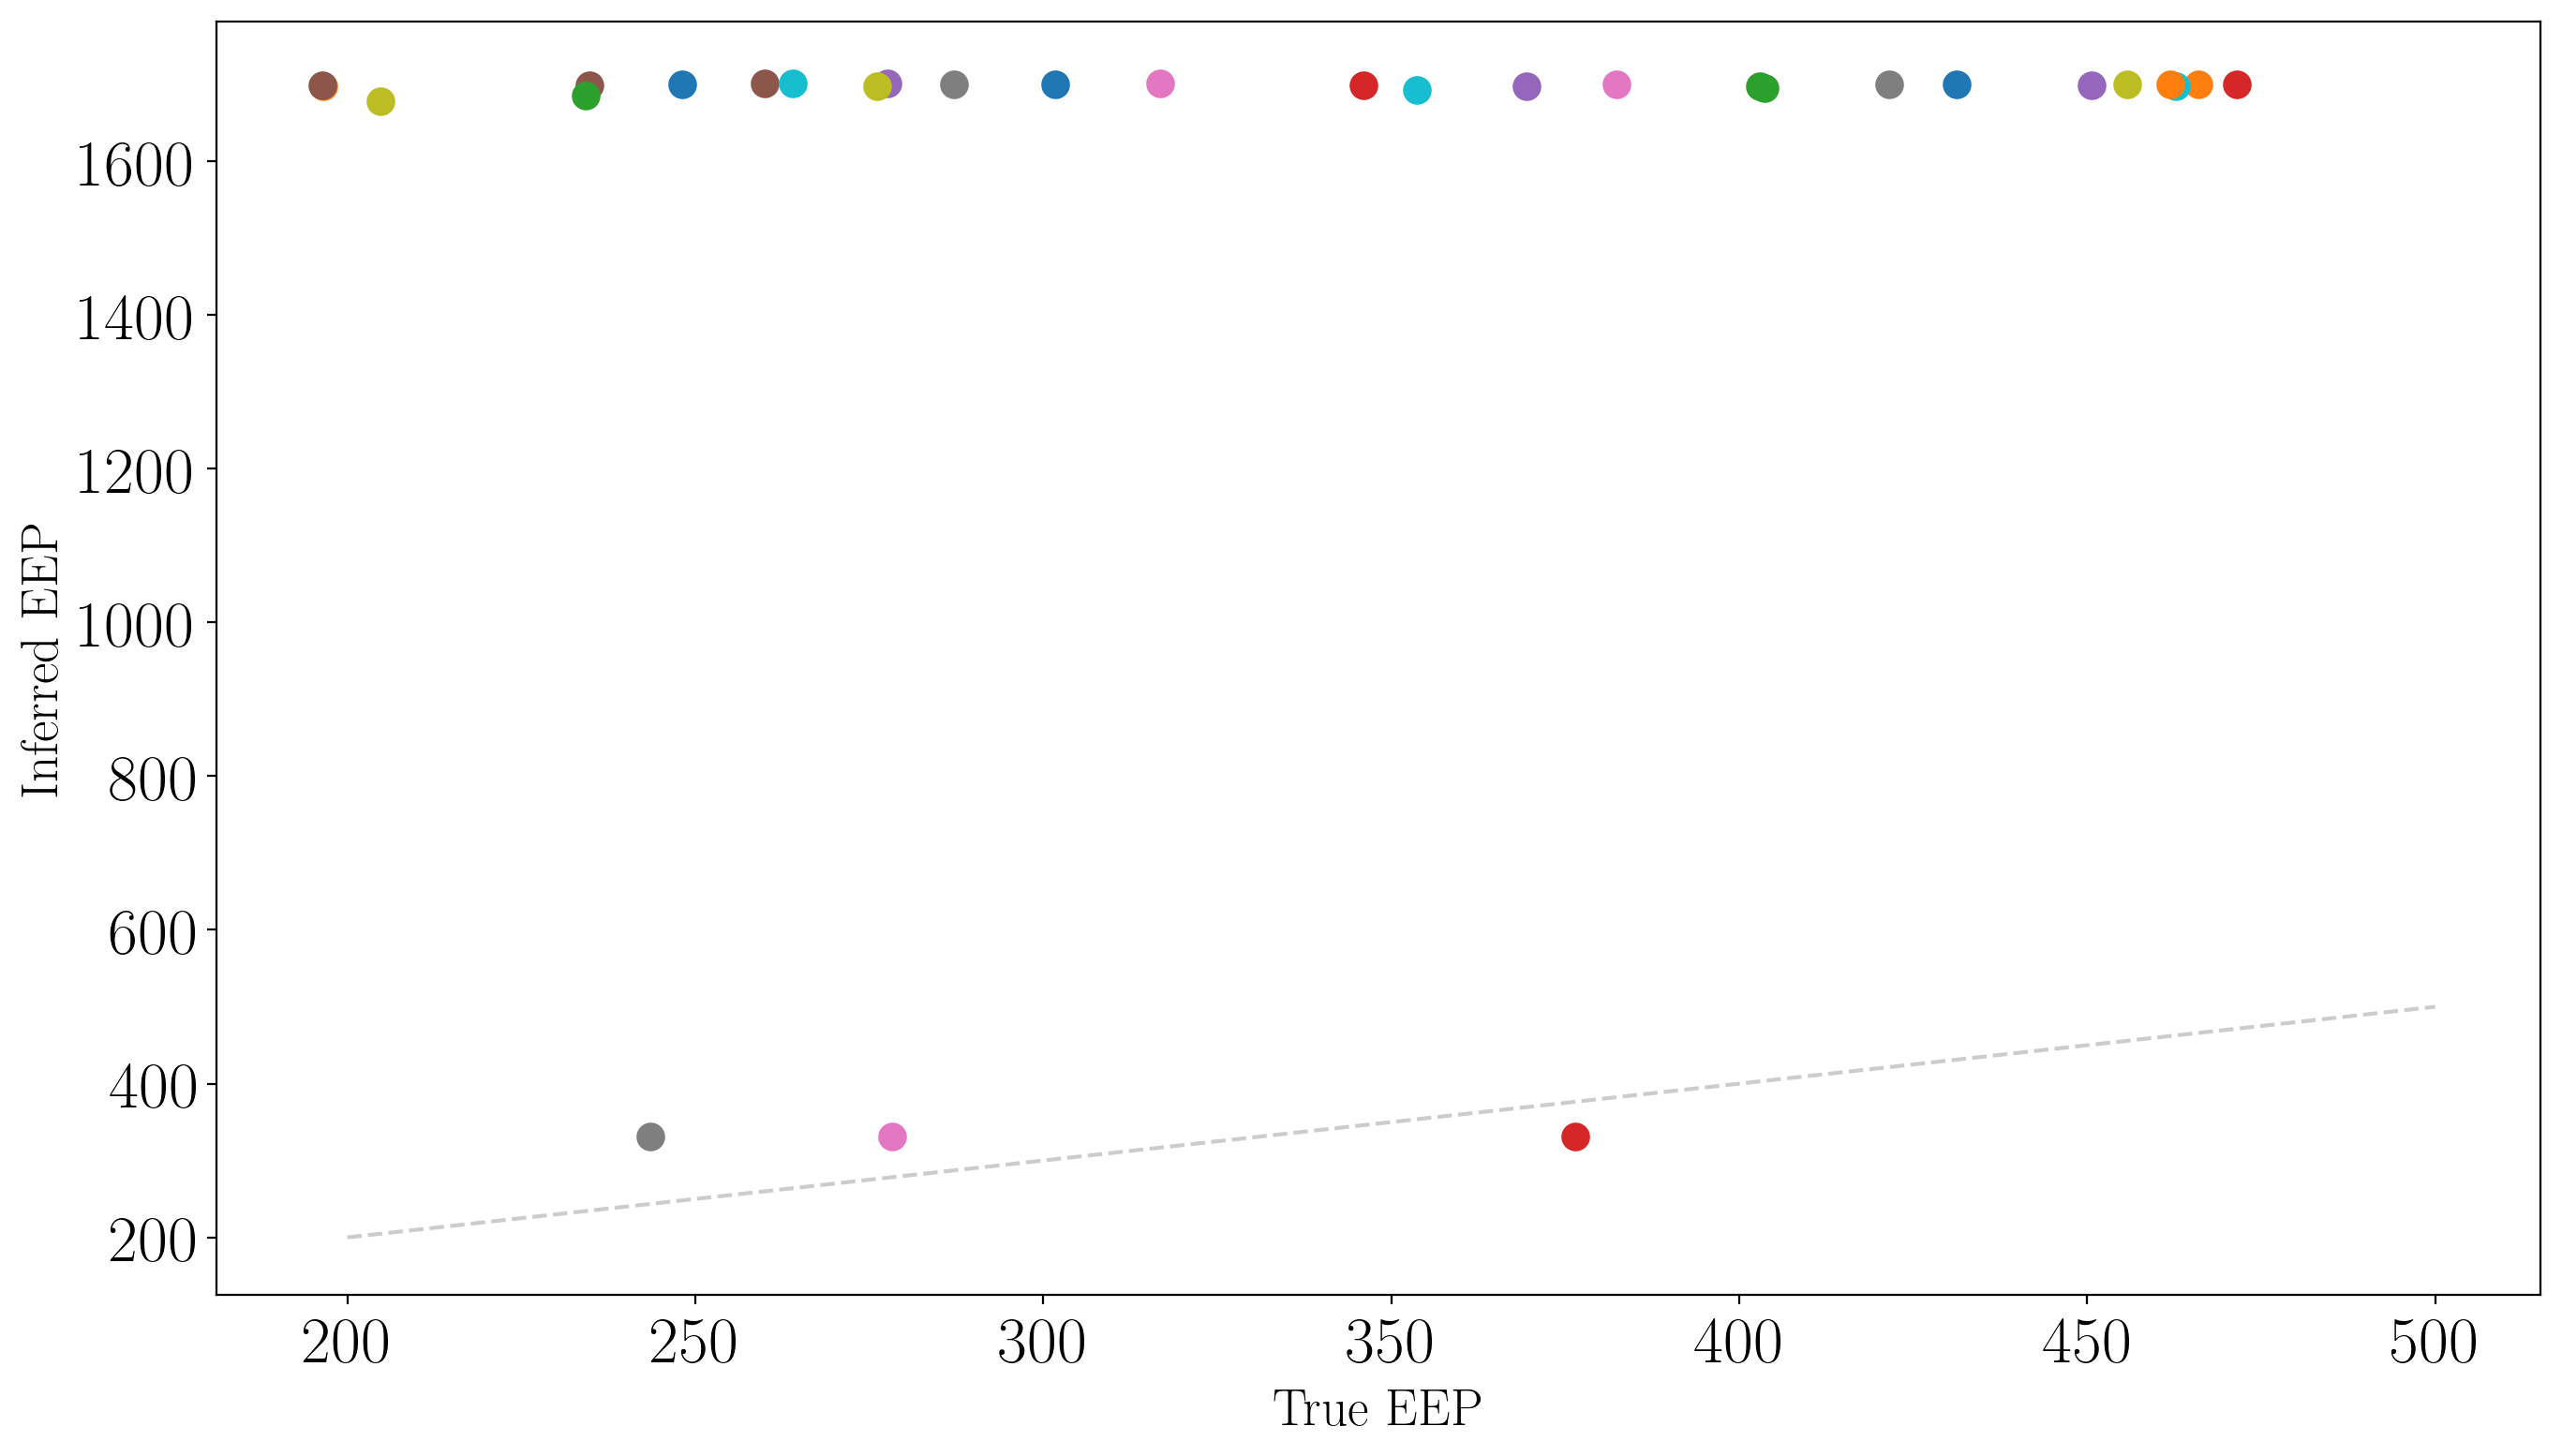

In [31]:
plt.figure(figsize=(16, 9), dpi=200)
for i in range(len(eeps)):
    plt.errorbar(df.eep.values[inds][i], eeps[i], yerr=eep_errp[i], ms=20, fmt=".", zorder=0)
plt.xlabel("$\mathrm{True~EEP}$")
plt.ylabel("$\mathrm{Inferred~EEP}$")
eep_xs = np.linspace(200, 500, 100)
plt.plot(eep_xs, eep_xs, ".5", ls="--", alpha=.4)

print(df.ID.values[inds][eeps/df.eep.values[inds] > 1.3])
print(df.ID.values[inds][eeps/df.eep.values[inds] < .8])
print(df.ID.values[inds][np.array(eeps) < 210.])

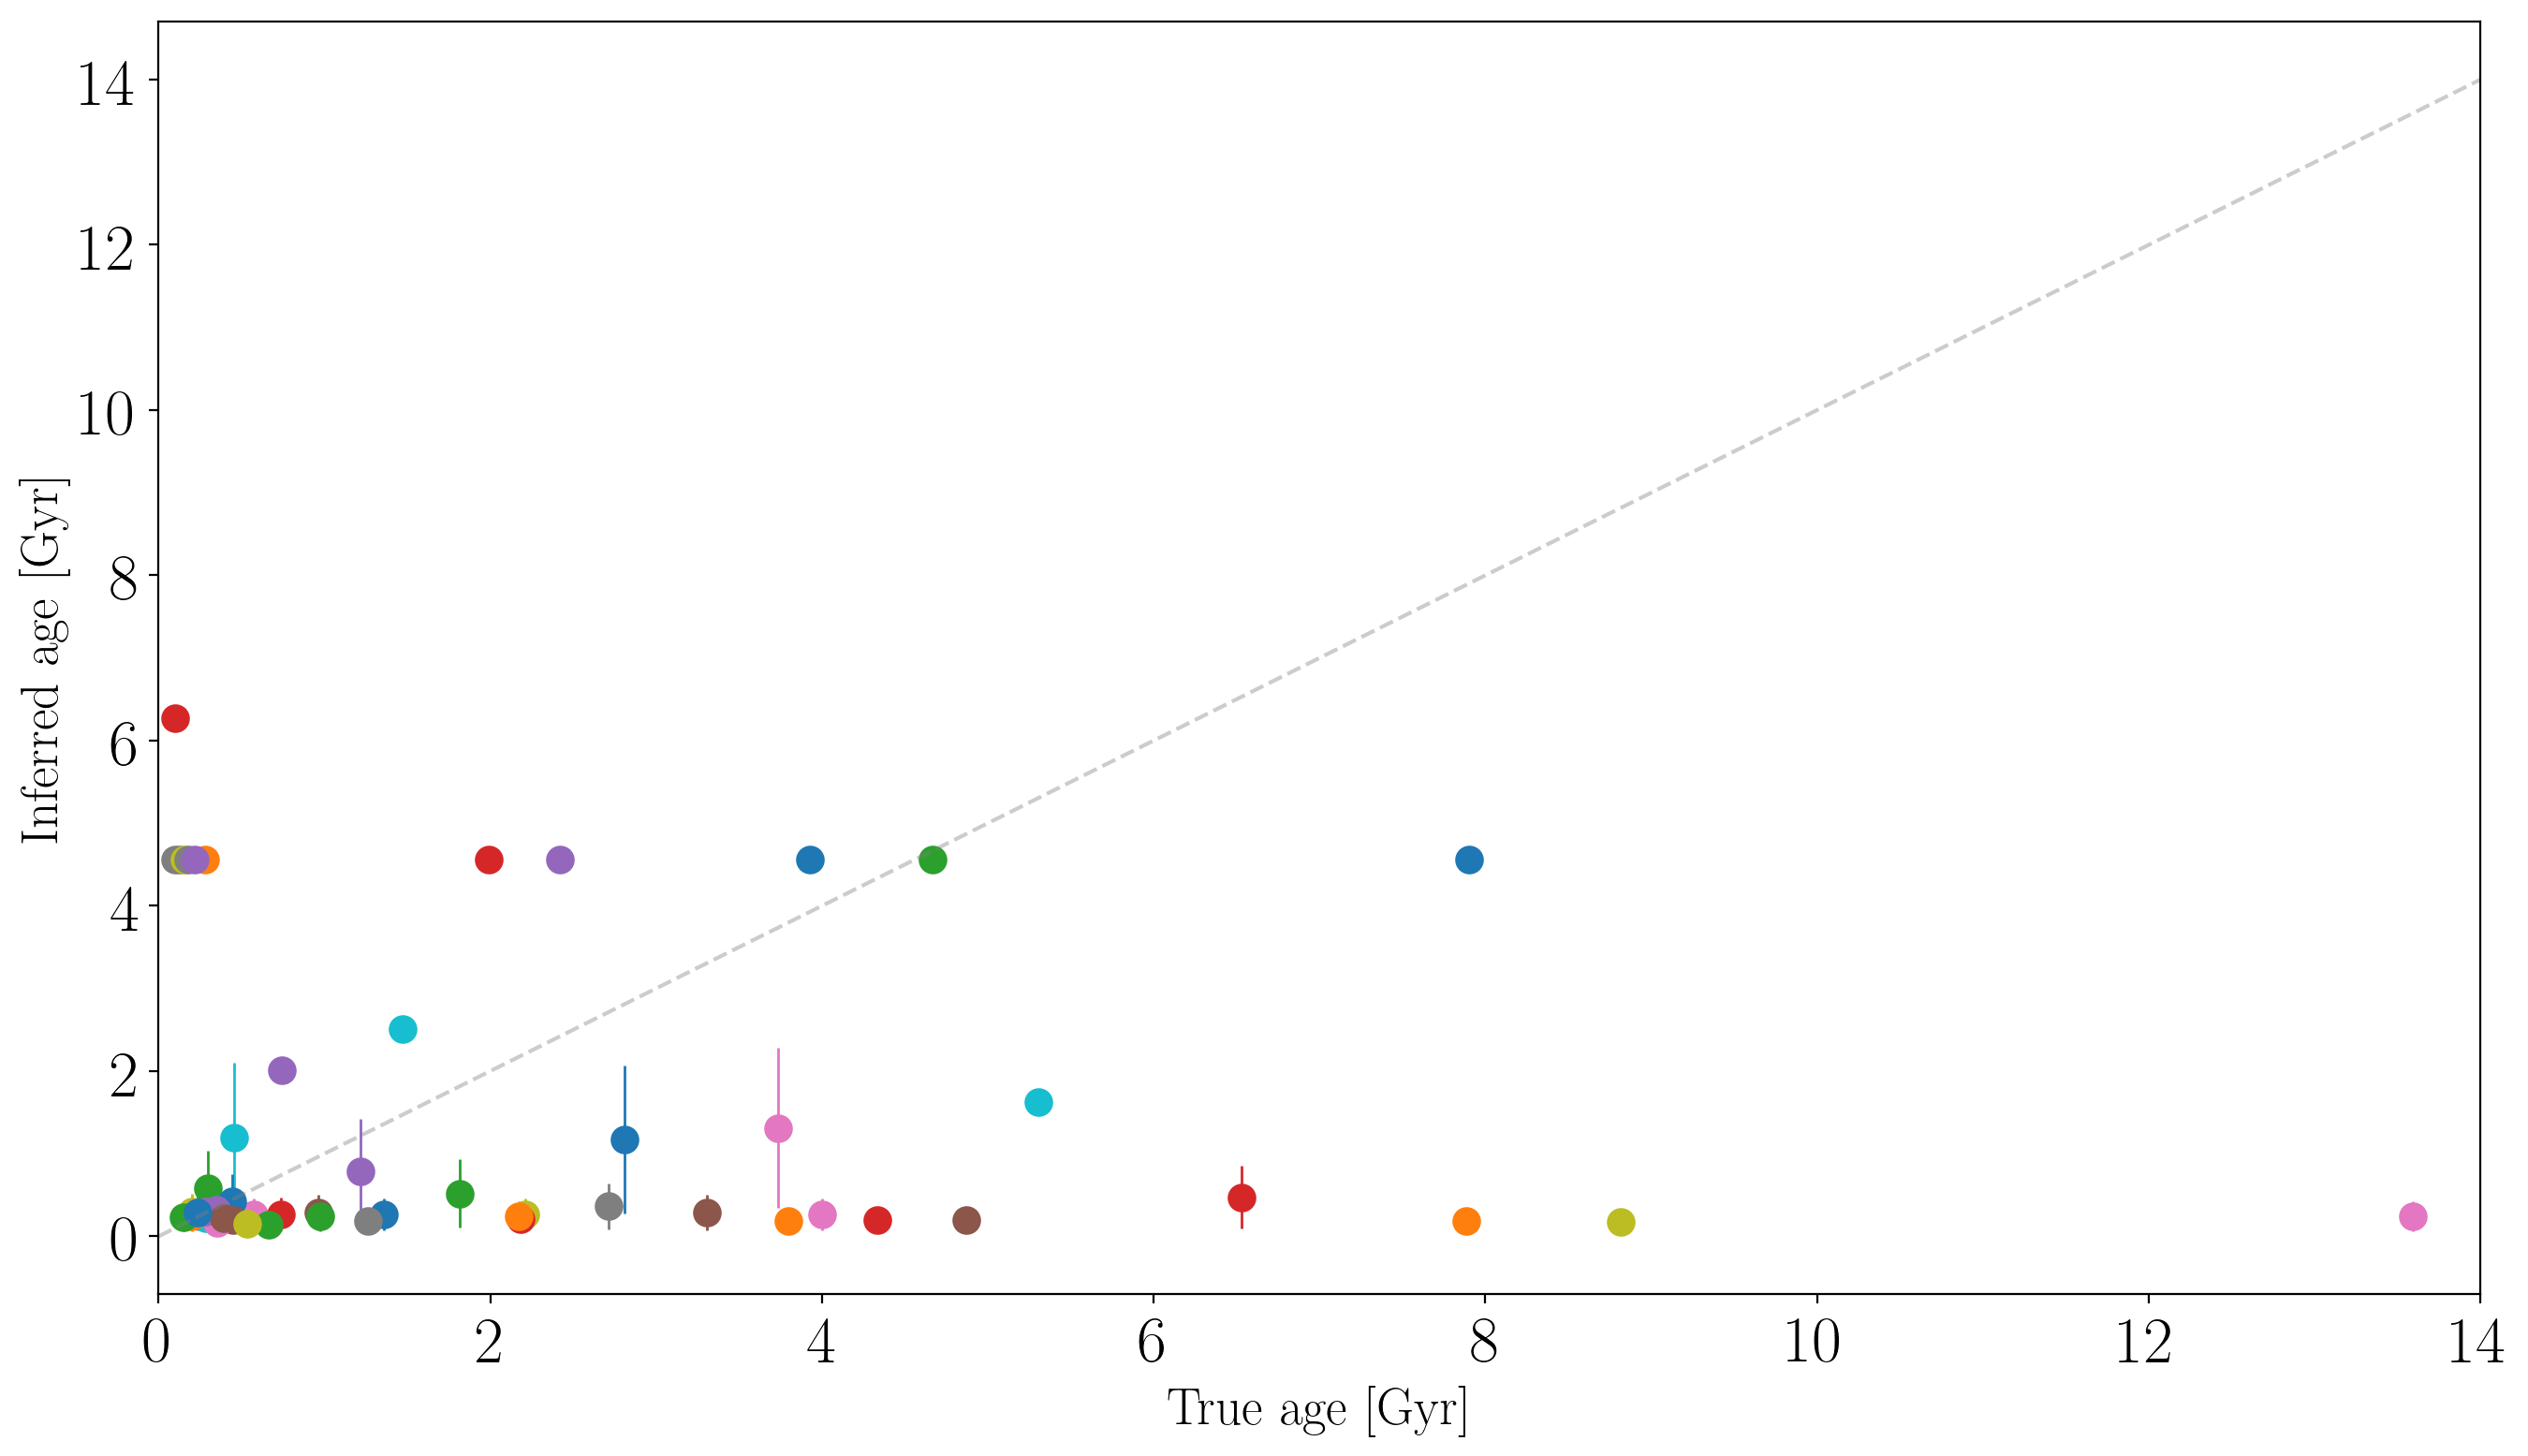

In [13]:
plt.figure(figsize=(16, 9), dpi=200)
for i in range(len(eeps)):
    plt.errorbar((10**df.age.values[inds][i])*1e-9, meds[i], yerr=errm[i], fmt=".", 
                 elinewidth=1, ms=20, zorder=0, rasterized=True)
# plt.errorbar((10**df.age.values[inds])*1e-9, meds, yerr=[errm, errp], fmt=".", color="k", 
#              elinewidth=1, alpha=.5, zorder=0, rasterized=True)
# plt.scatter((10**df.age.values[inds])*1e-9, meds, c=df.eep.values[inds], s=50, zorder=1, rasterized=True)
            
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
# plt.colorbar(label="$\mathrm{Equivalent~Evolutionary~Point}$")
plt.savefig("iso_and_gyro.pdf")

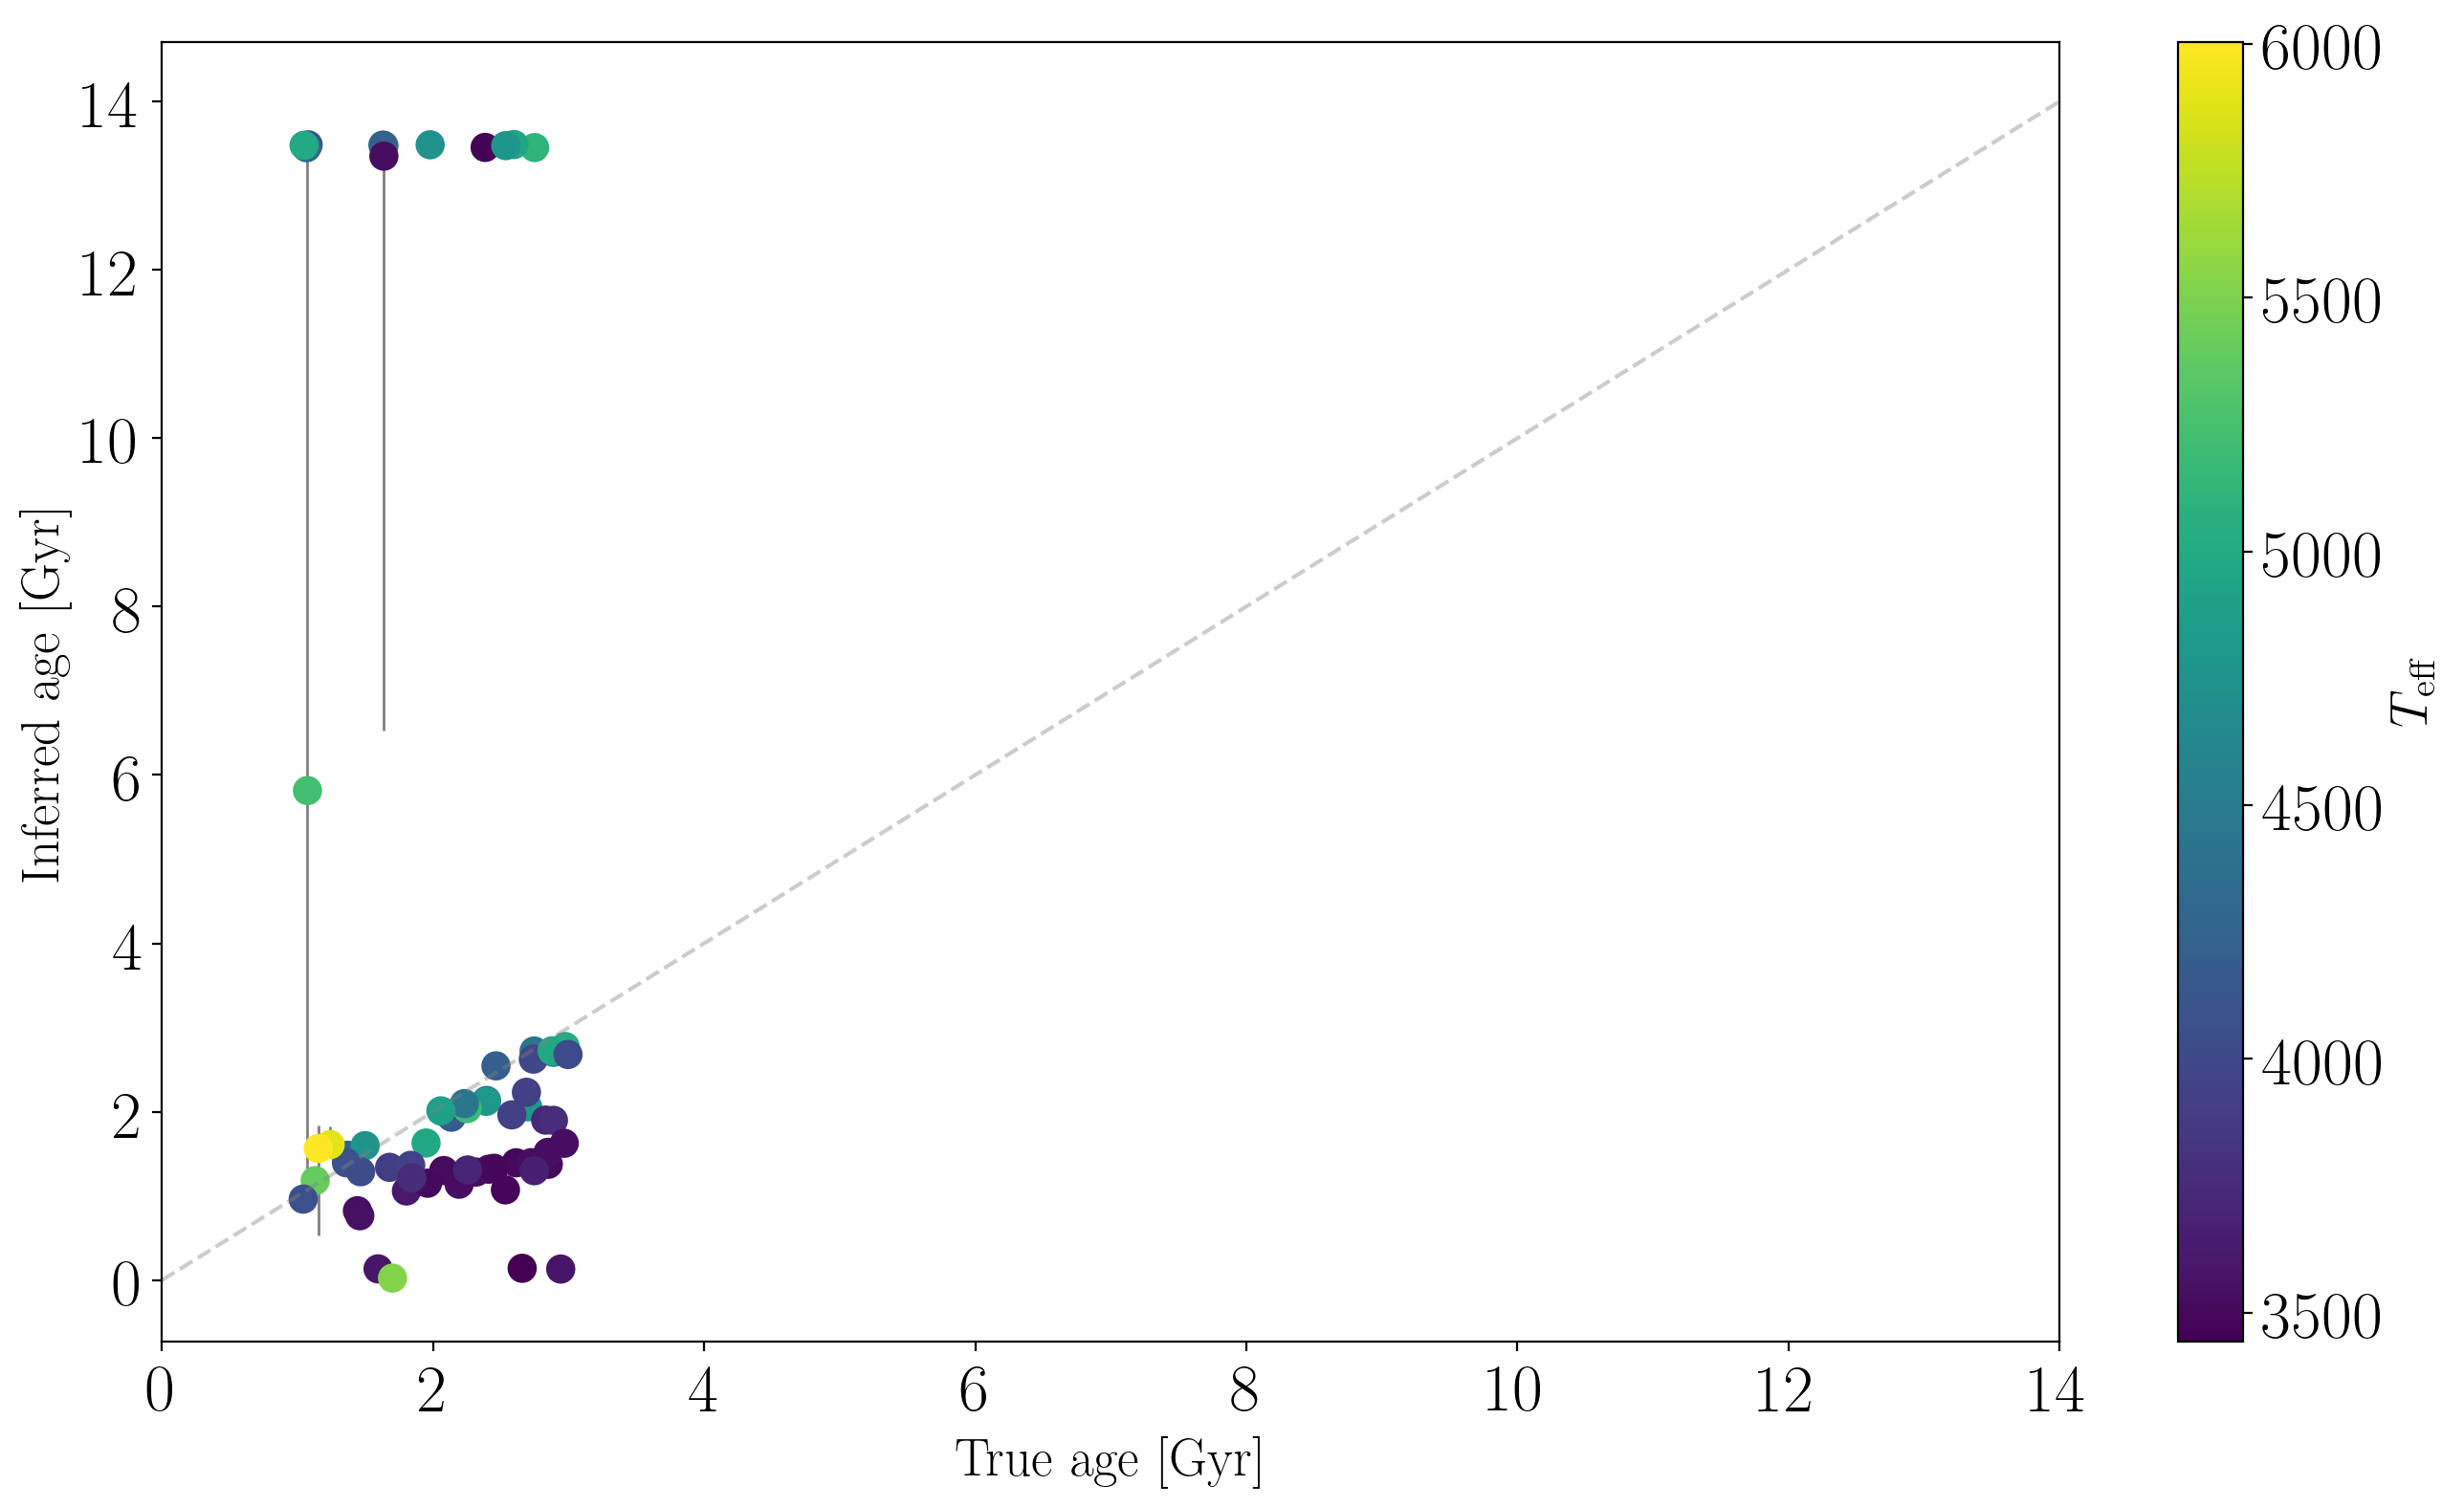

In [313]:
plt.figure(figsize=(16, 9), dpi=200)
plt.errorbar((10**df.age.values[inds])*1e-9, meds, yerr=[errm, errp], fmt=".", color="k", 
             elinewidth=1, alpha=.5, zorder=0, rasterized=True)
plt.scatter((10**df.age.values[inds])*1e-9, meds, c=df.teff.values[inds], s=100, zorder=1, rasterized=True)
            
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.colorbar(label="$T_\mathrm{eff}$")
plt.savefig("iso_and_gyro.pdf")

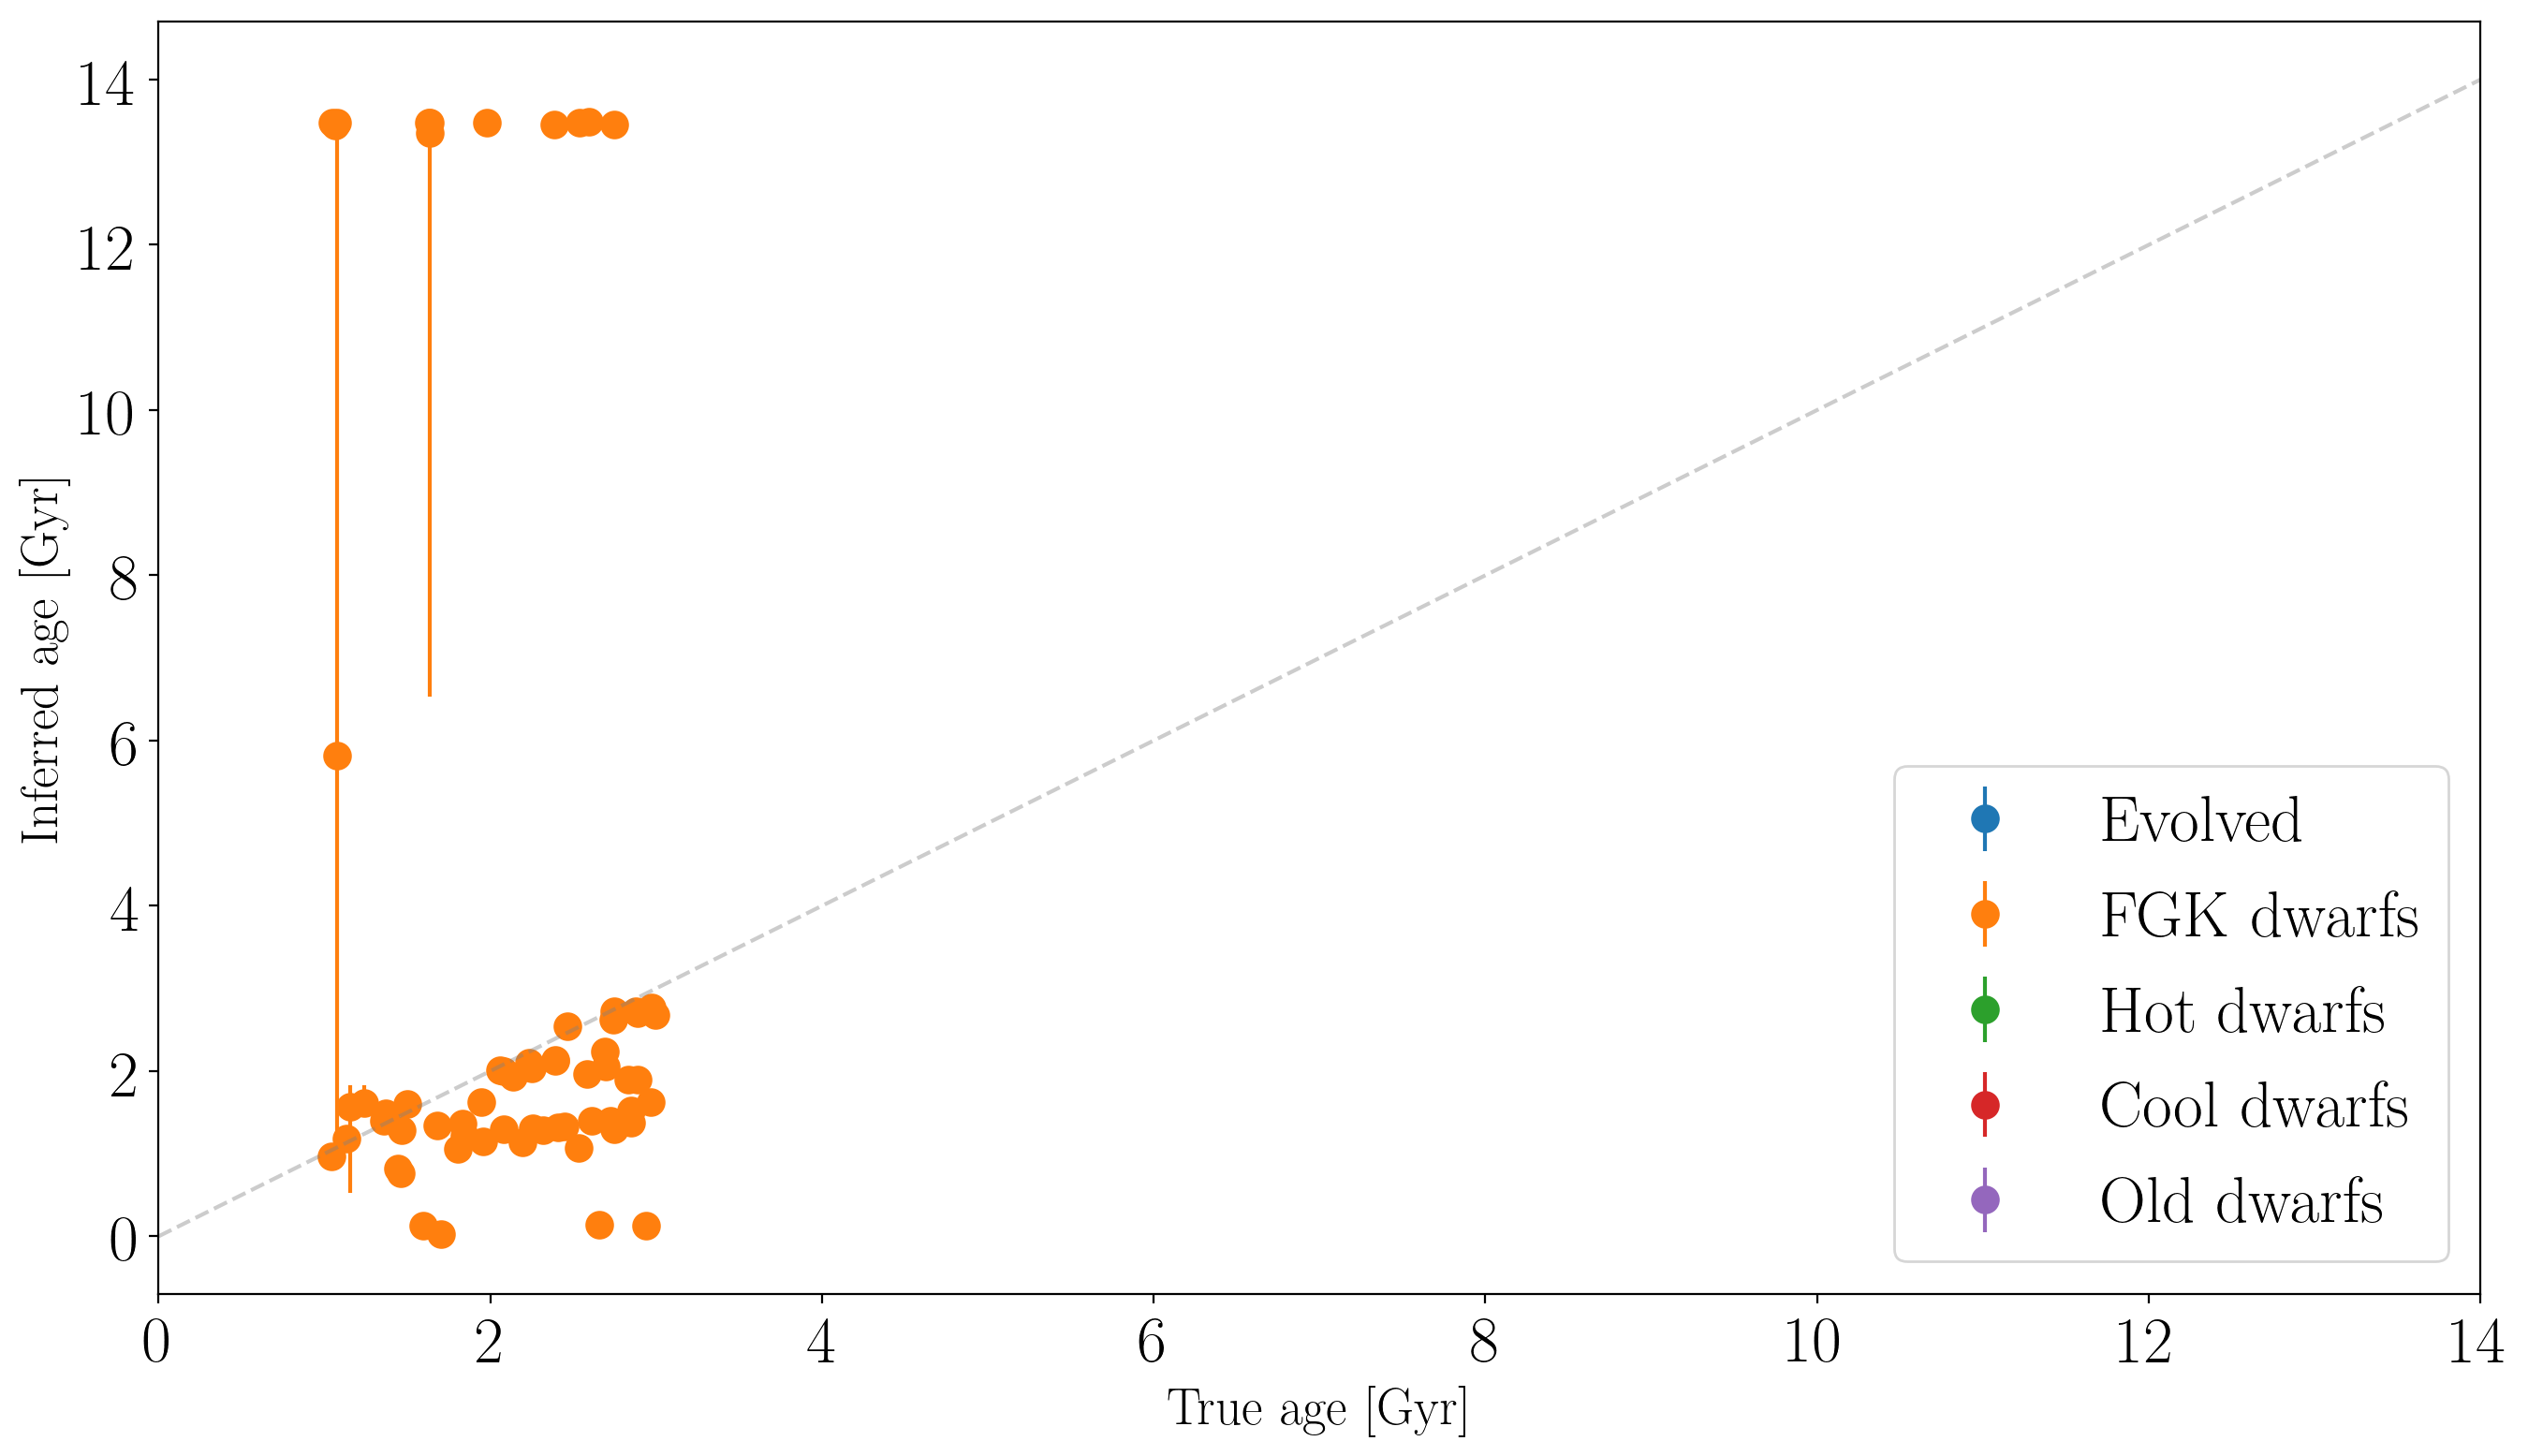

In [314]:
plt.figure(figsize=(16, 9), dpi=200)
m = (df.eep.values[inds] > 400)
hot = df.BV.values[inds] < .45
cool = np.log10(df.BV.values[inds]) > 1
Ro = df.prot.values[inds]/convective_overturn_time(df.mass.values[inds])
rossbied = Ro > 2.1
true_age_gyr = (10**df.age.values)*1e-9

plt.errorbar(true_age_gyr[inds][m], meds[m], yerr=[errm[m], errp[m]], fmt=".", ms=20, zorder=0,
             label="$\mathrm{Evolved}$", rasterized=True)
plt.errorbar(true_age_gyr[inds][~m], meds[~m], yerr=[errm[~m], errp[~m]], fmt=".", ms=20, zorder=0,
             label="$\mathrm{FGK~dwarfs}$", rasterized=True)
plt.errorbar(true_age_gyr[inds][hot], meds[hot], yerr=[errm[hot], errp[hot]], fmt=".", 
             ms=20, zorder=0, label="$\mathrm{Hot~dwarfs}$", rasterized=True)
plt.errorbar(true_age_gyr[inds][cool], meds[cool], yerr=[errm[cool], errp[cool]], fmt=".", 
             ms=20, zorder=0, label="$\mathrm{Cool~dwarfs}$", rasterized=True)
plt.errorbar(true_age_gyr[inds][rossbied], meds[rossbied], yerr=[errm[rossbied], errp[rossbied]], fmt=".", 
             ms=20, zorder=0, label="$\mathrm{Old~dwarfs}$", rasterized=True)

plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.legend()

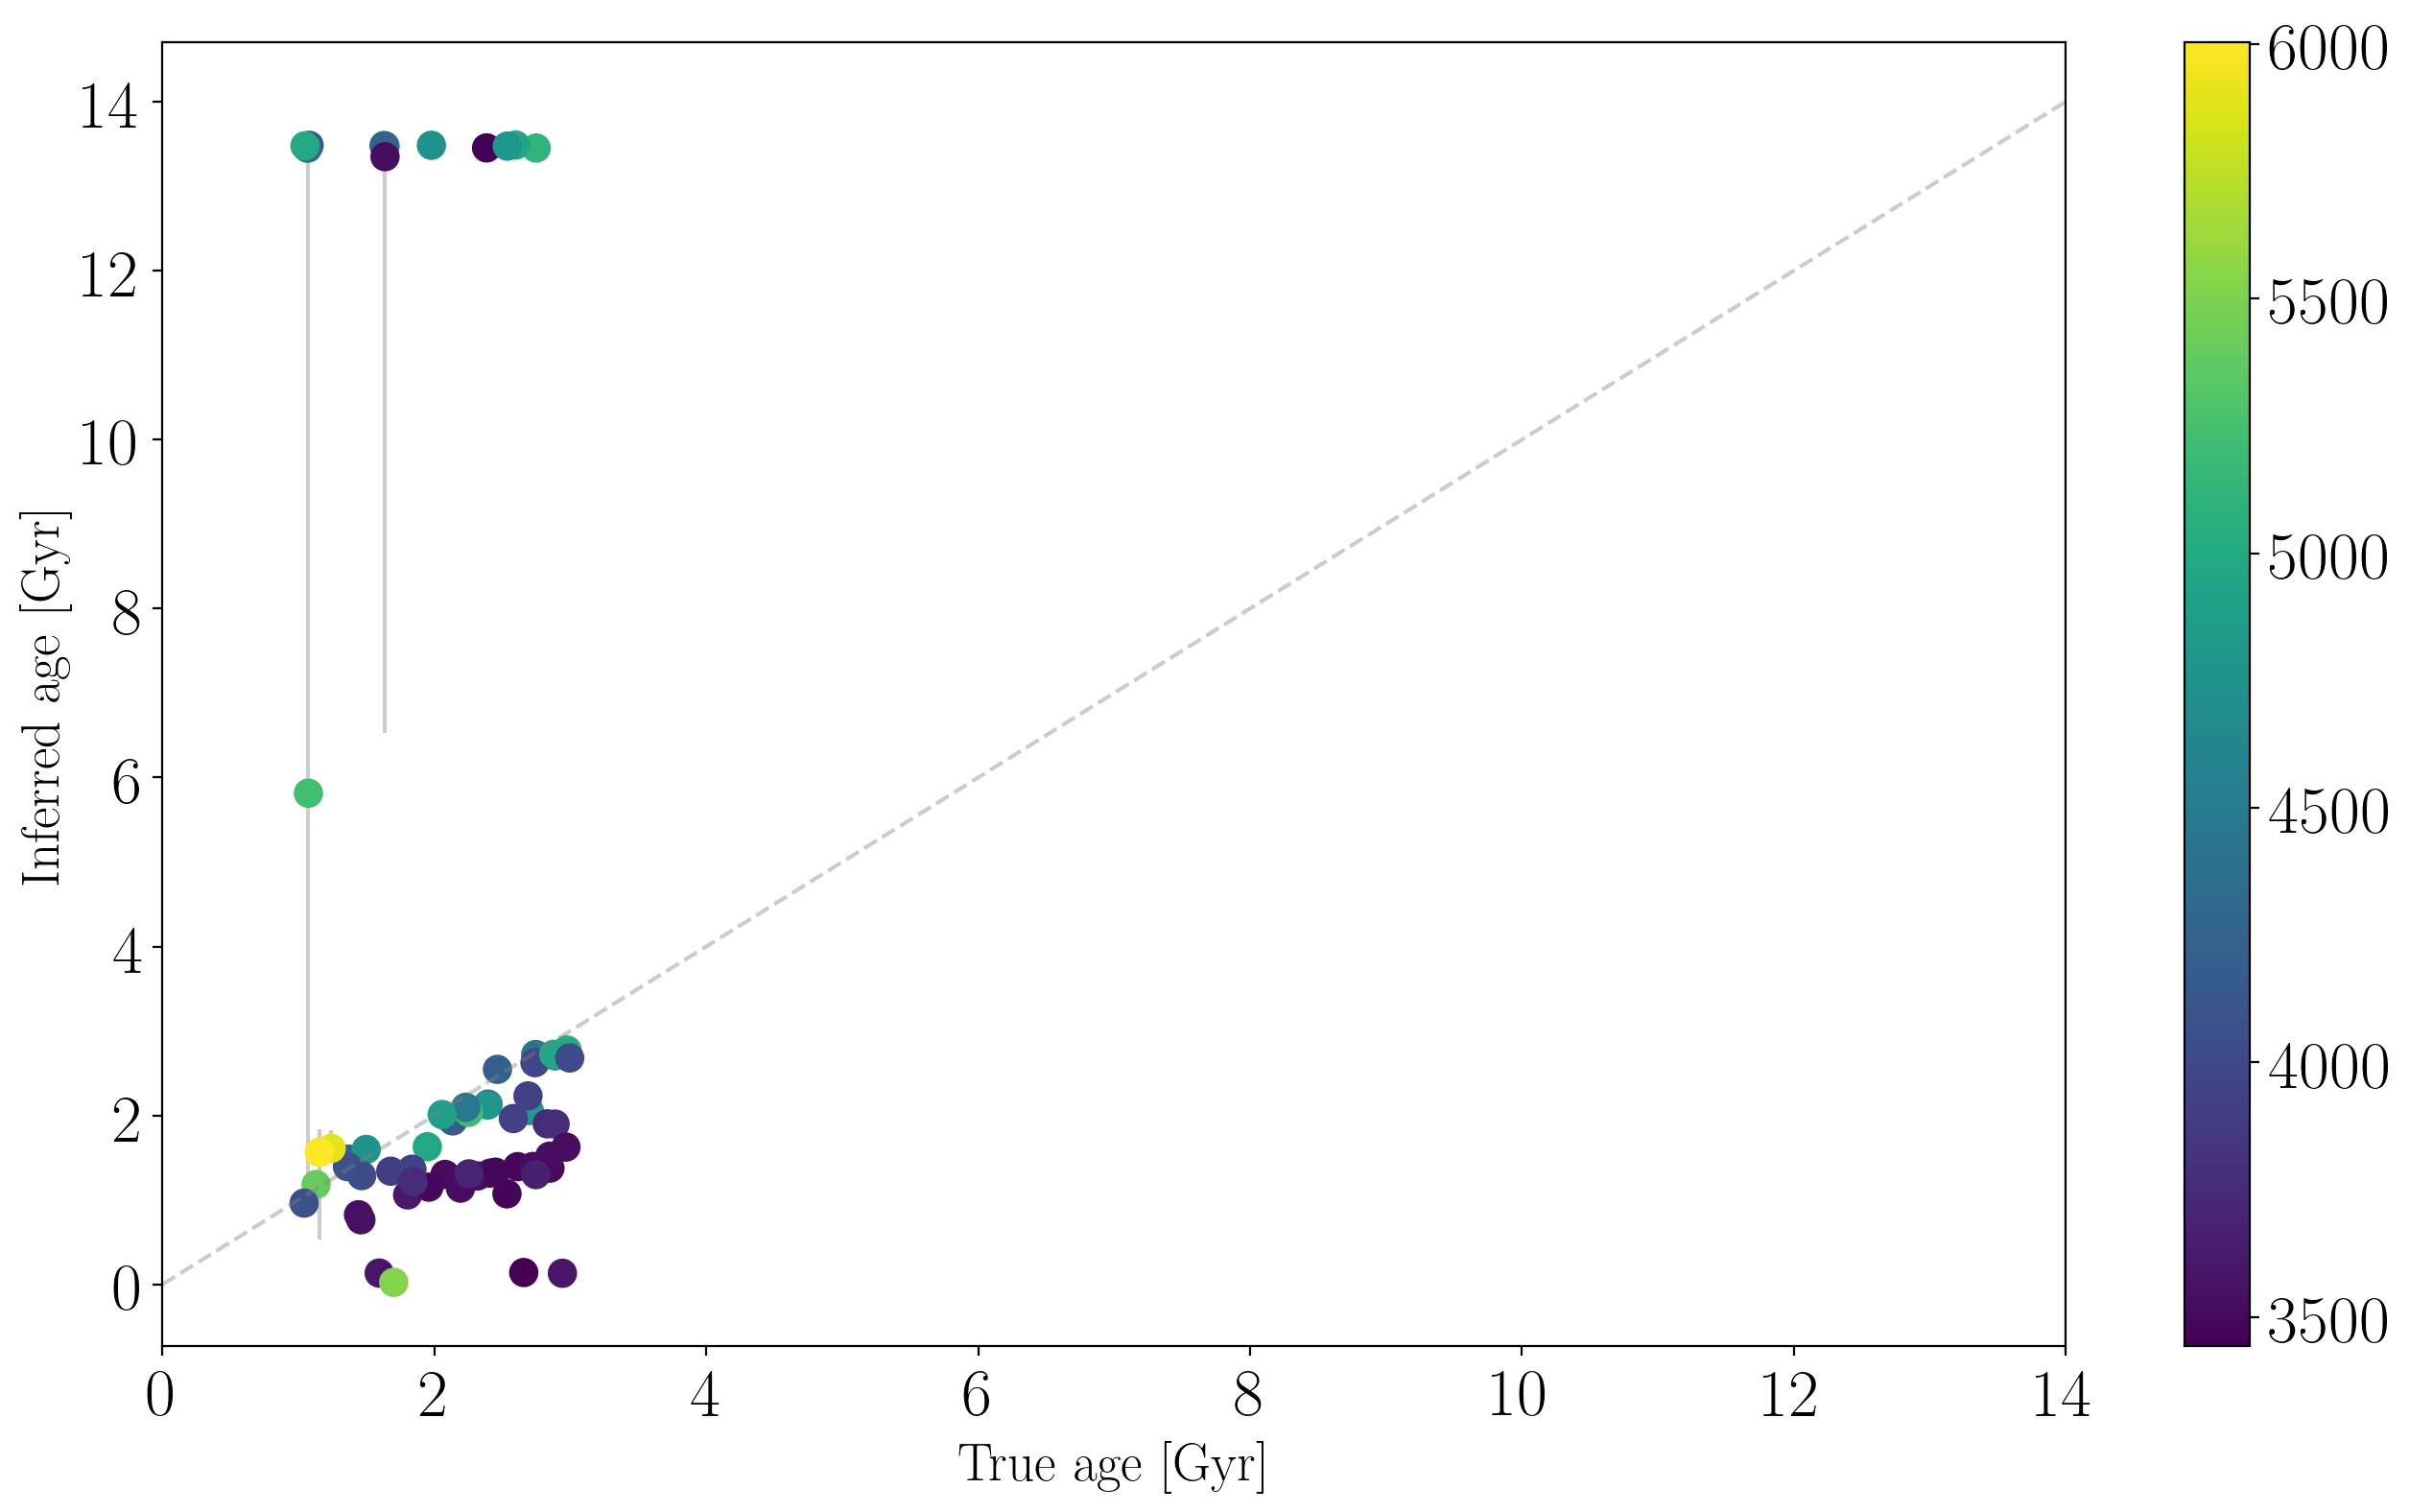

In [315]:
plt.figure(figsize=(16, 9), dpi=200)
plt.errorbar(true_age_gyr[inds], meds, yerr=[errm, errp], fmt=".", color="k",
             alpha=.2, zorder=0)
plt.scatter(true_age_gyr[inds], meds, c=df.teff.values[inds], s=100, zorder=1)  
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.colorbar()

NameError: name 'true_age_gyr' is not defined

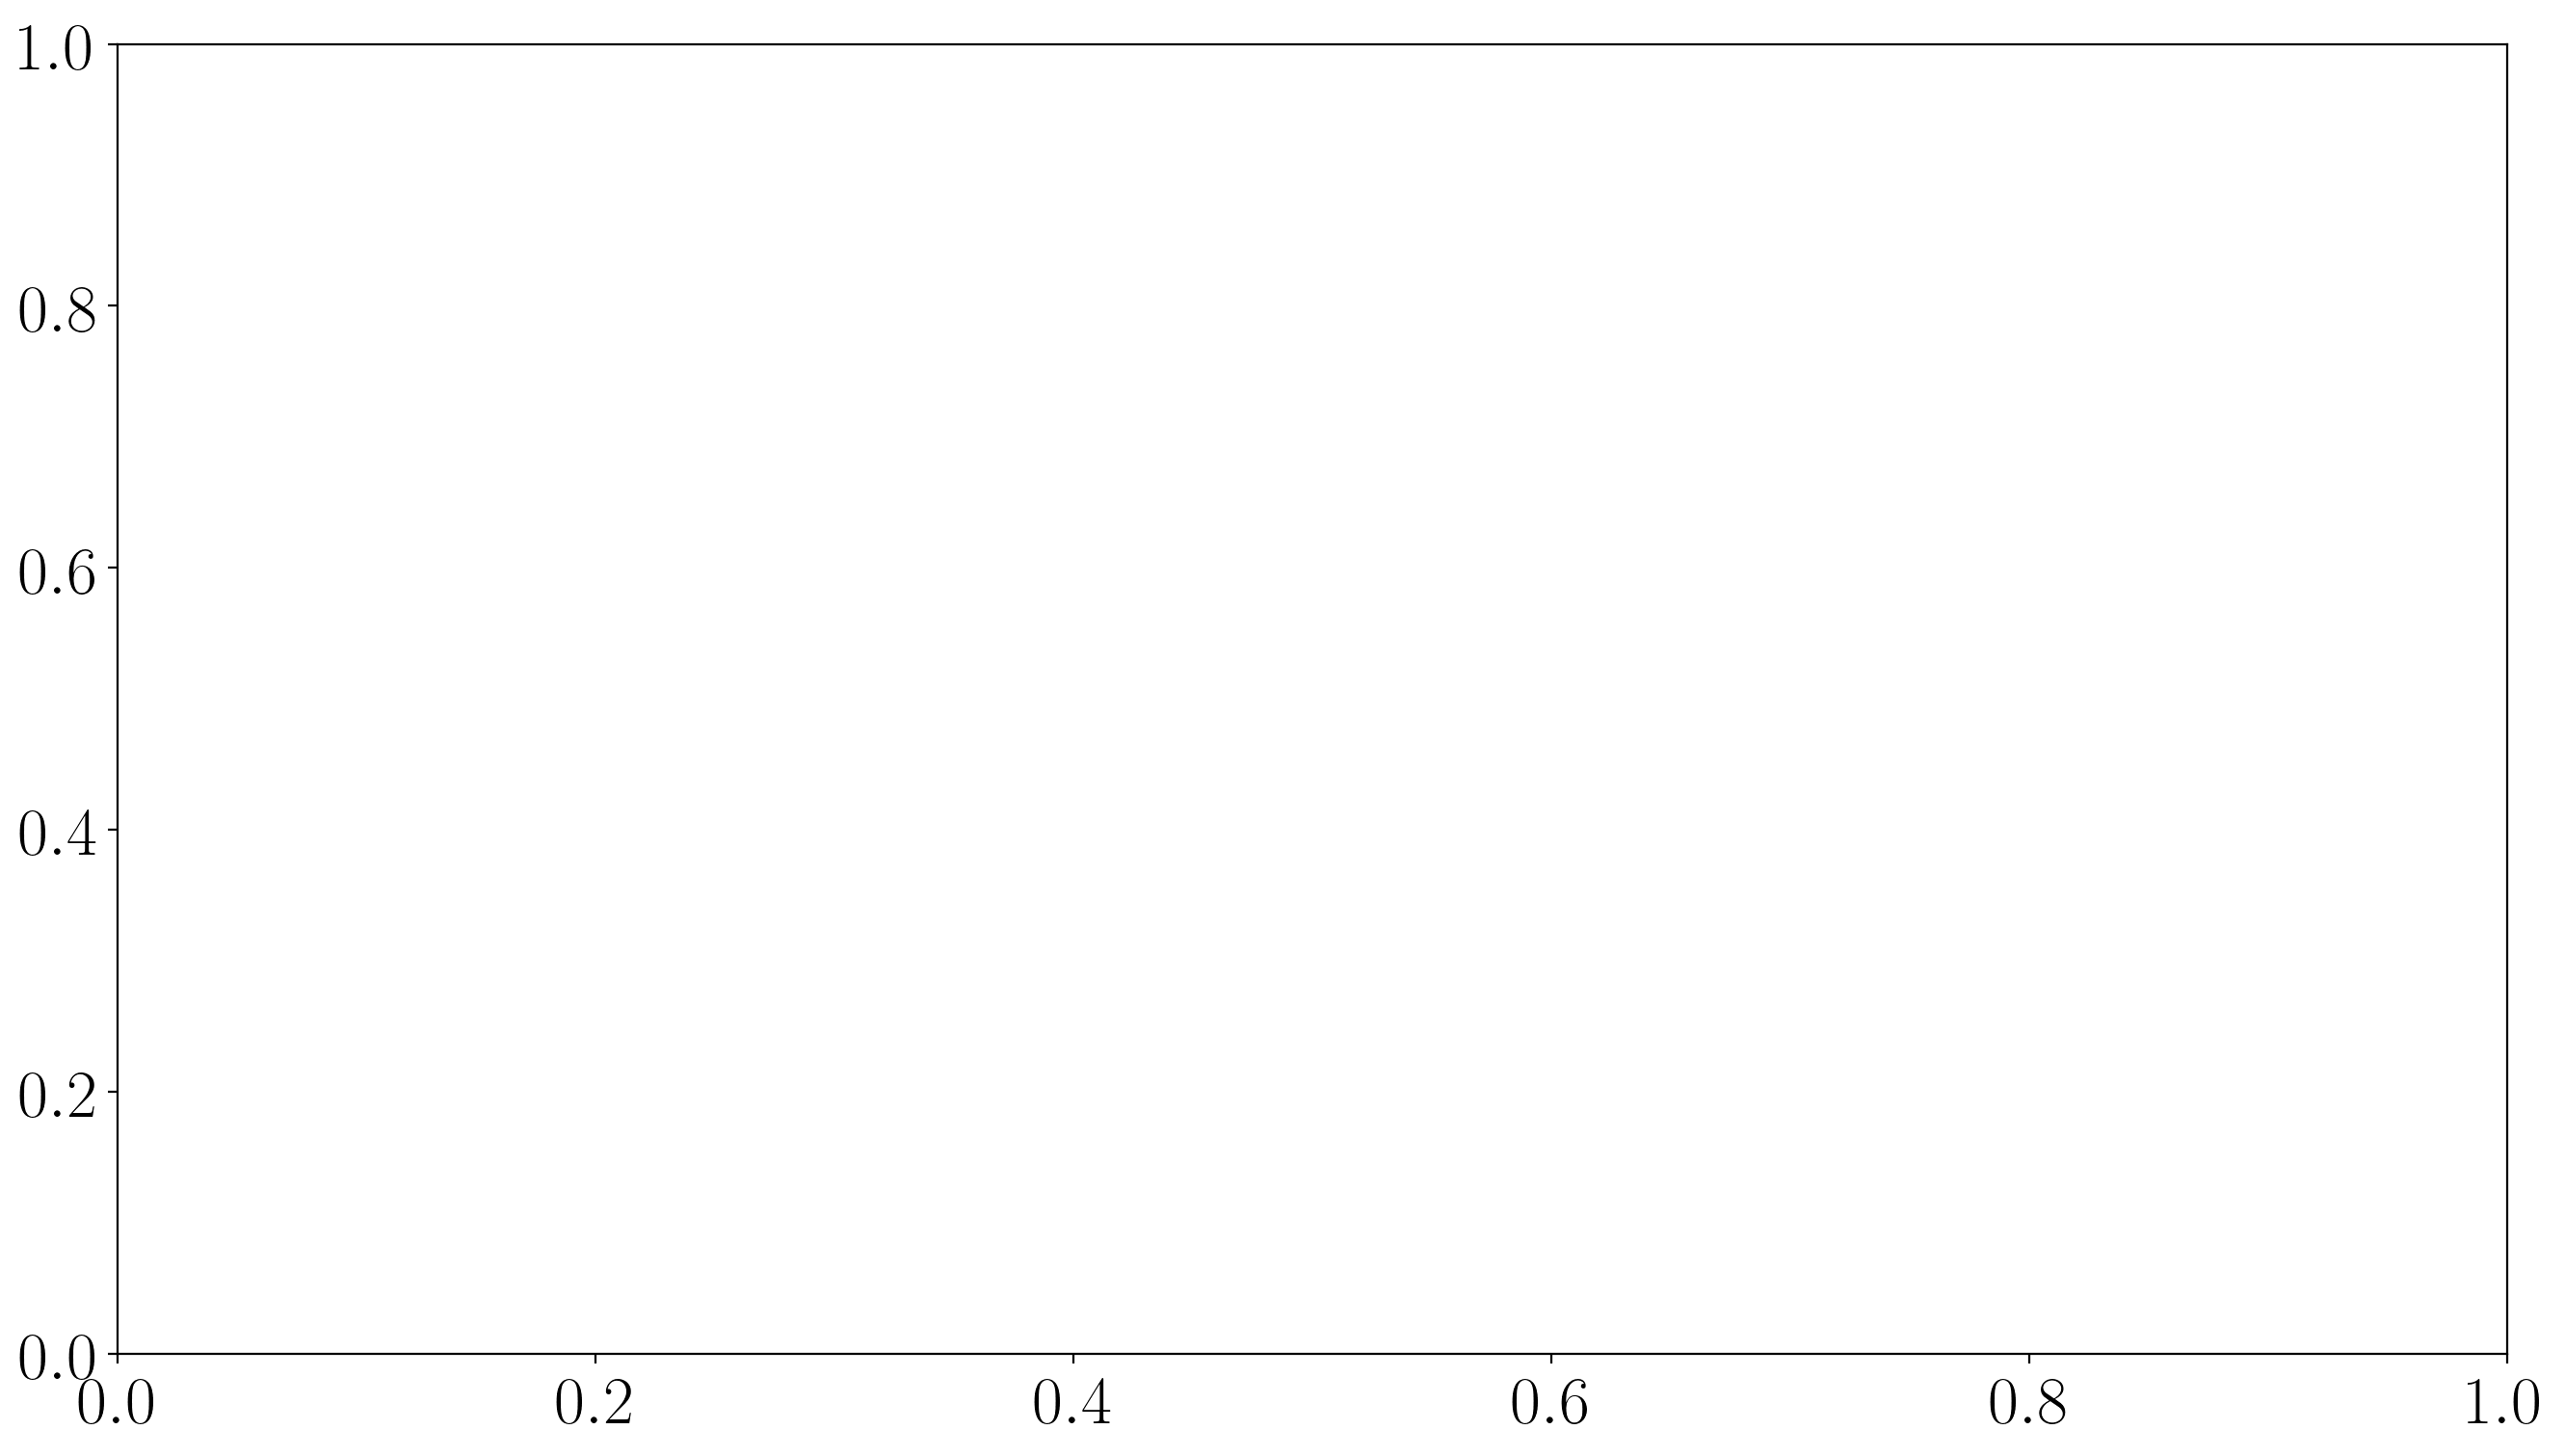

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 9), dpi=200)
axes.violinplot(age_samps, true_age_gyr[inds], points=50, widths=0.3,
                showmeans=False, showextrema=False, showmedians=True)
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)

Precision plot

Text(0, 0.5, '$\\log(g)$')

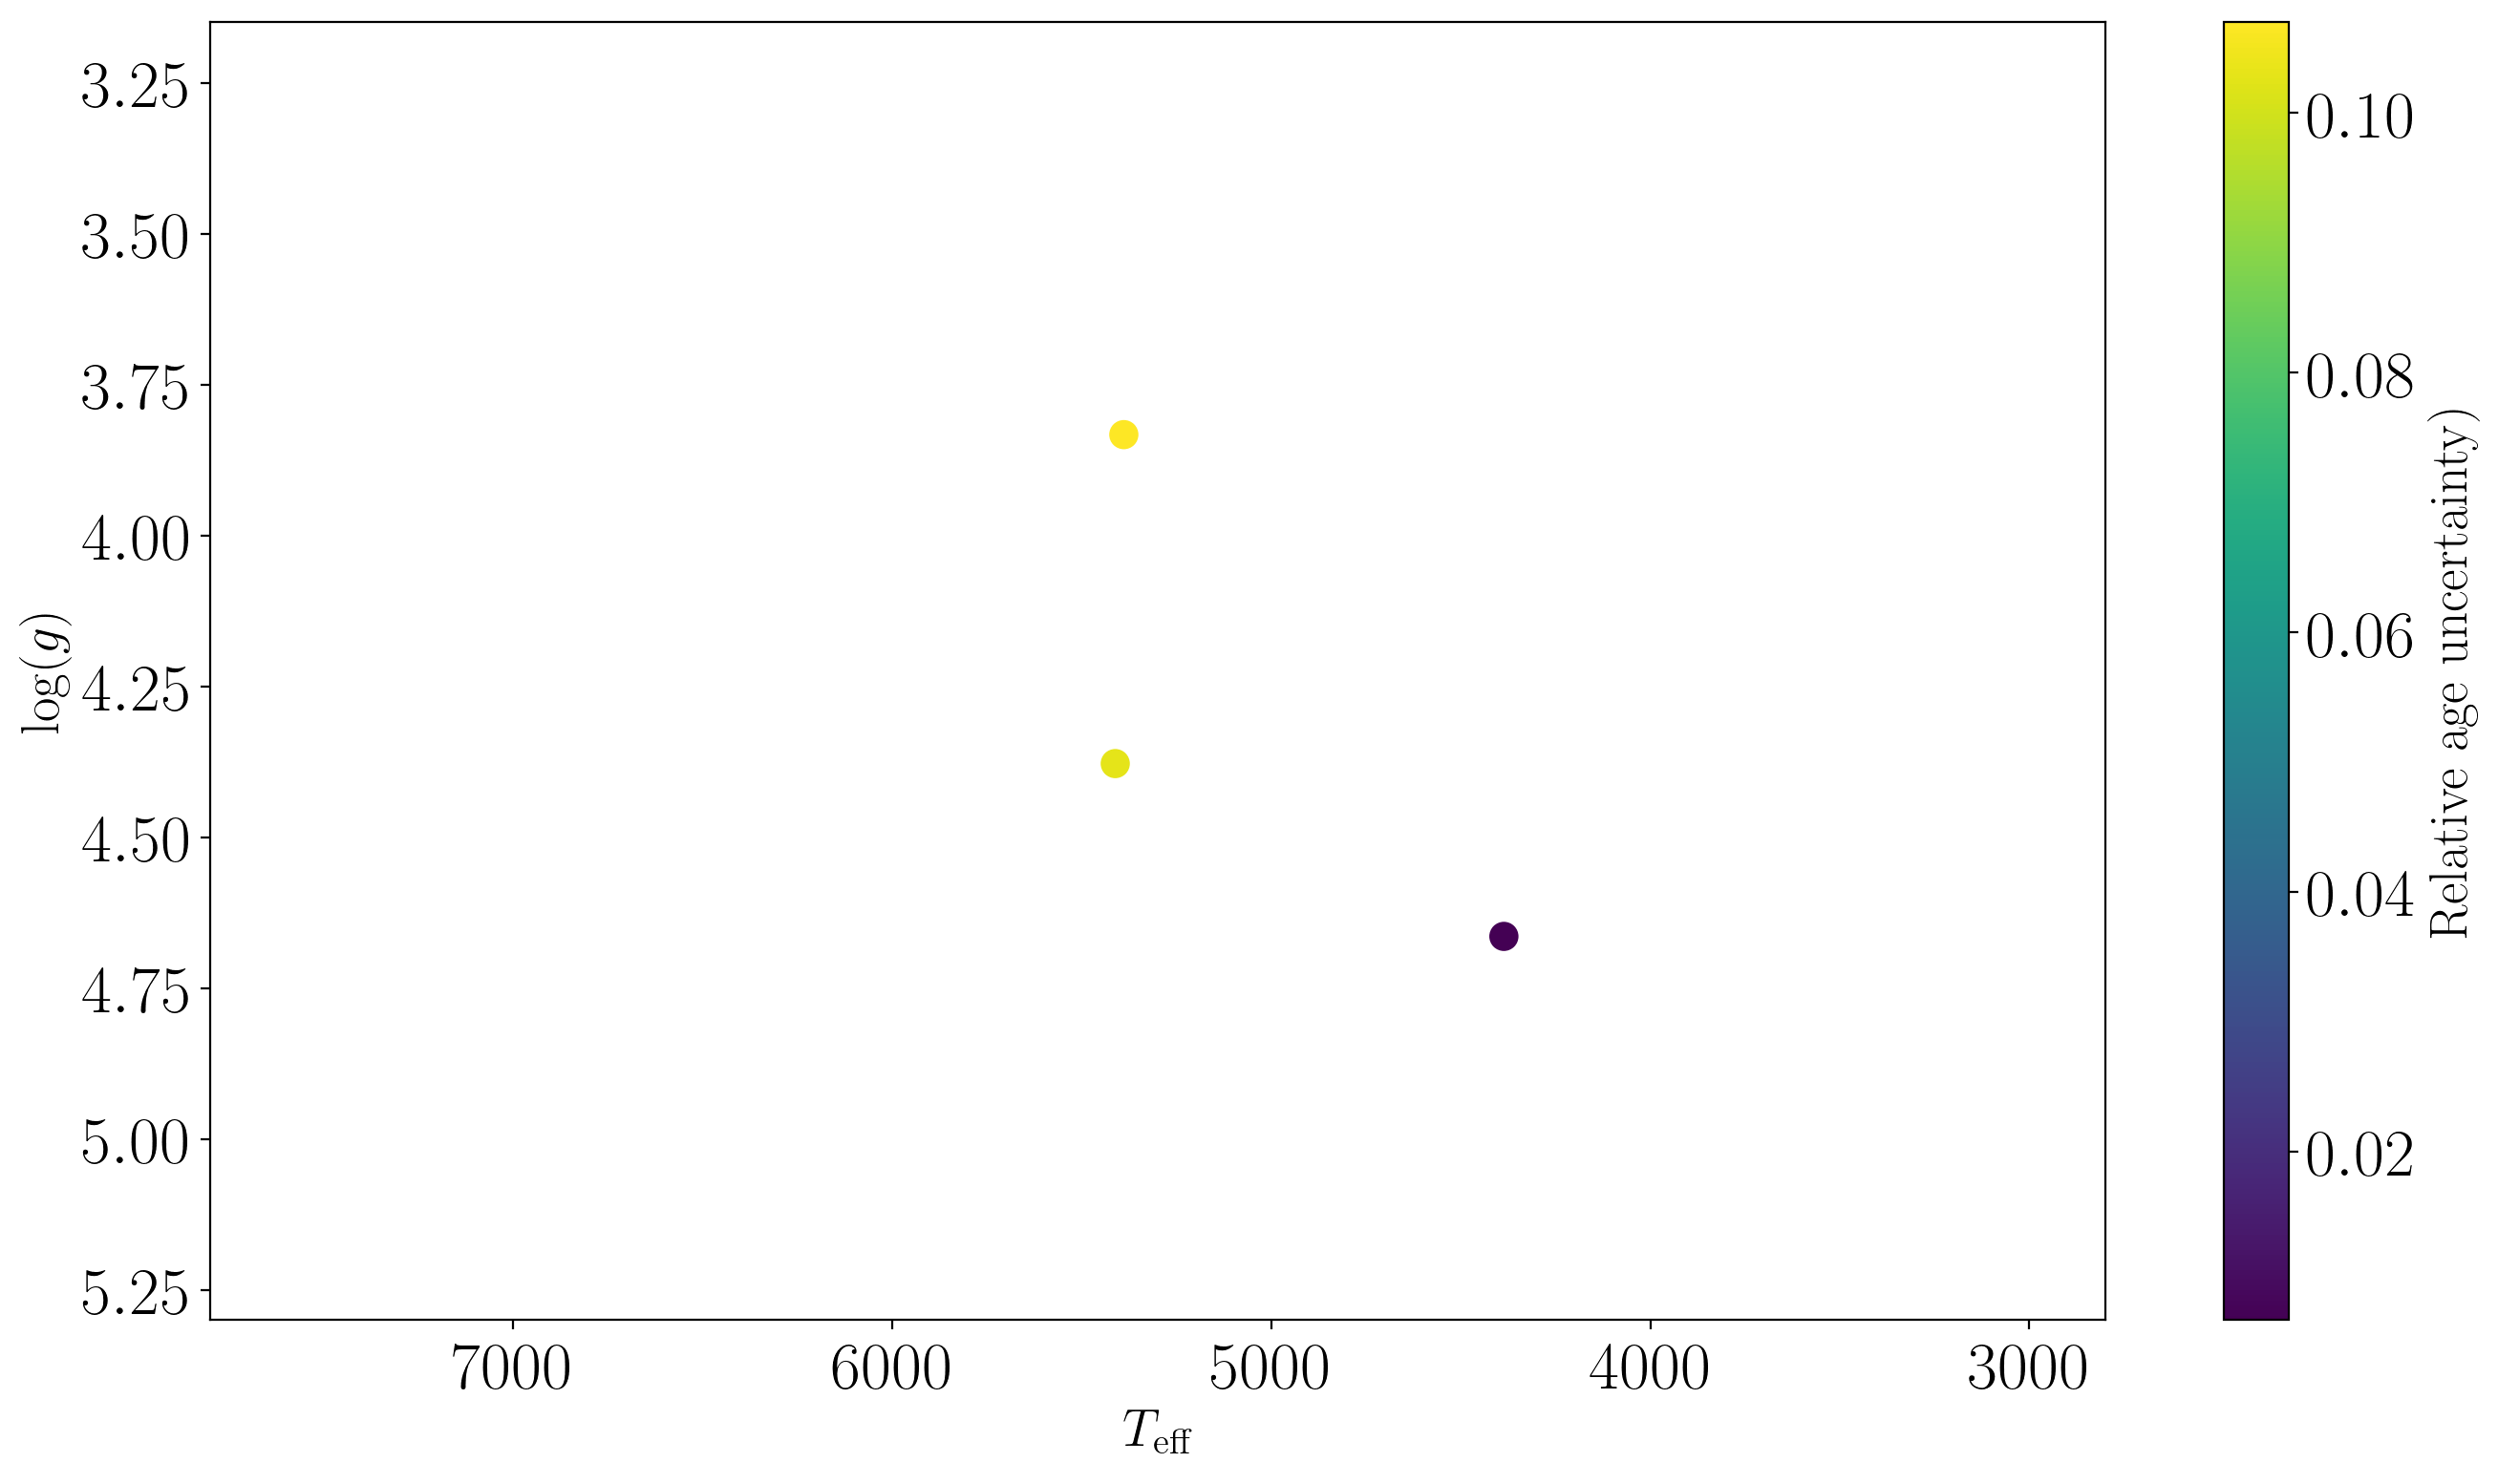

In [122]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff.values[:N], df.logg.values[:N], c=stds/df.age.values[:N], s=100)
plt.colorbar(label="$\mathrm{Relative~age~uncertainty})$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

Error plot (accuracy)

Text(0, 0.5, '$\\log(g)$')

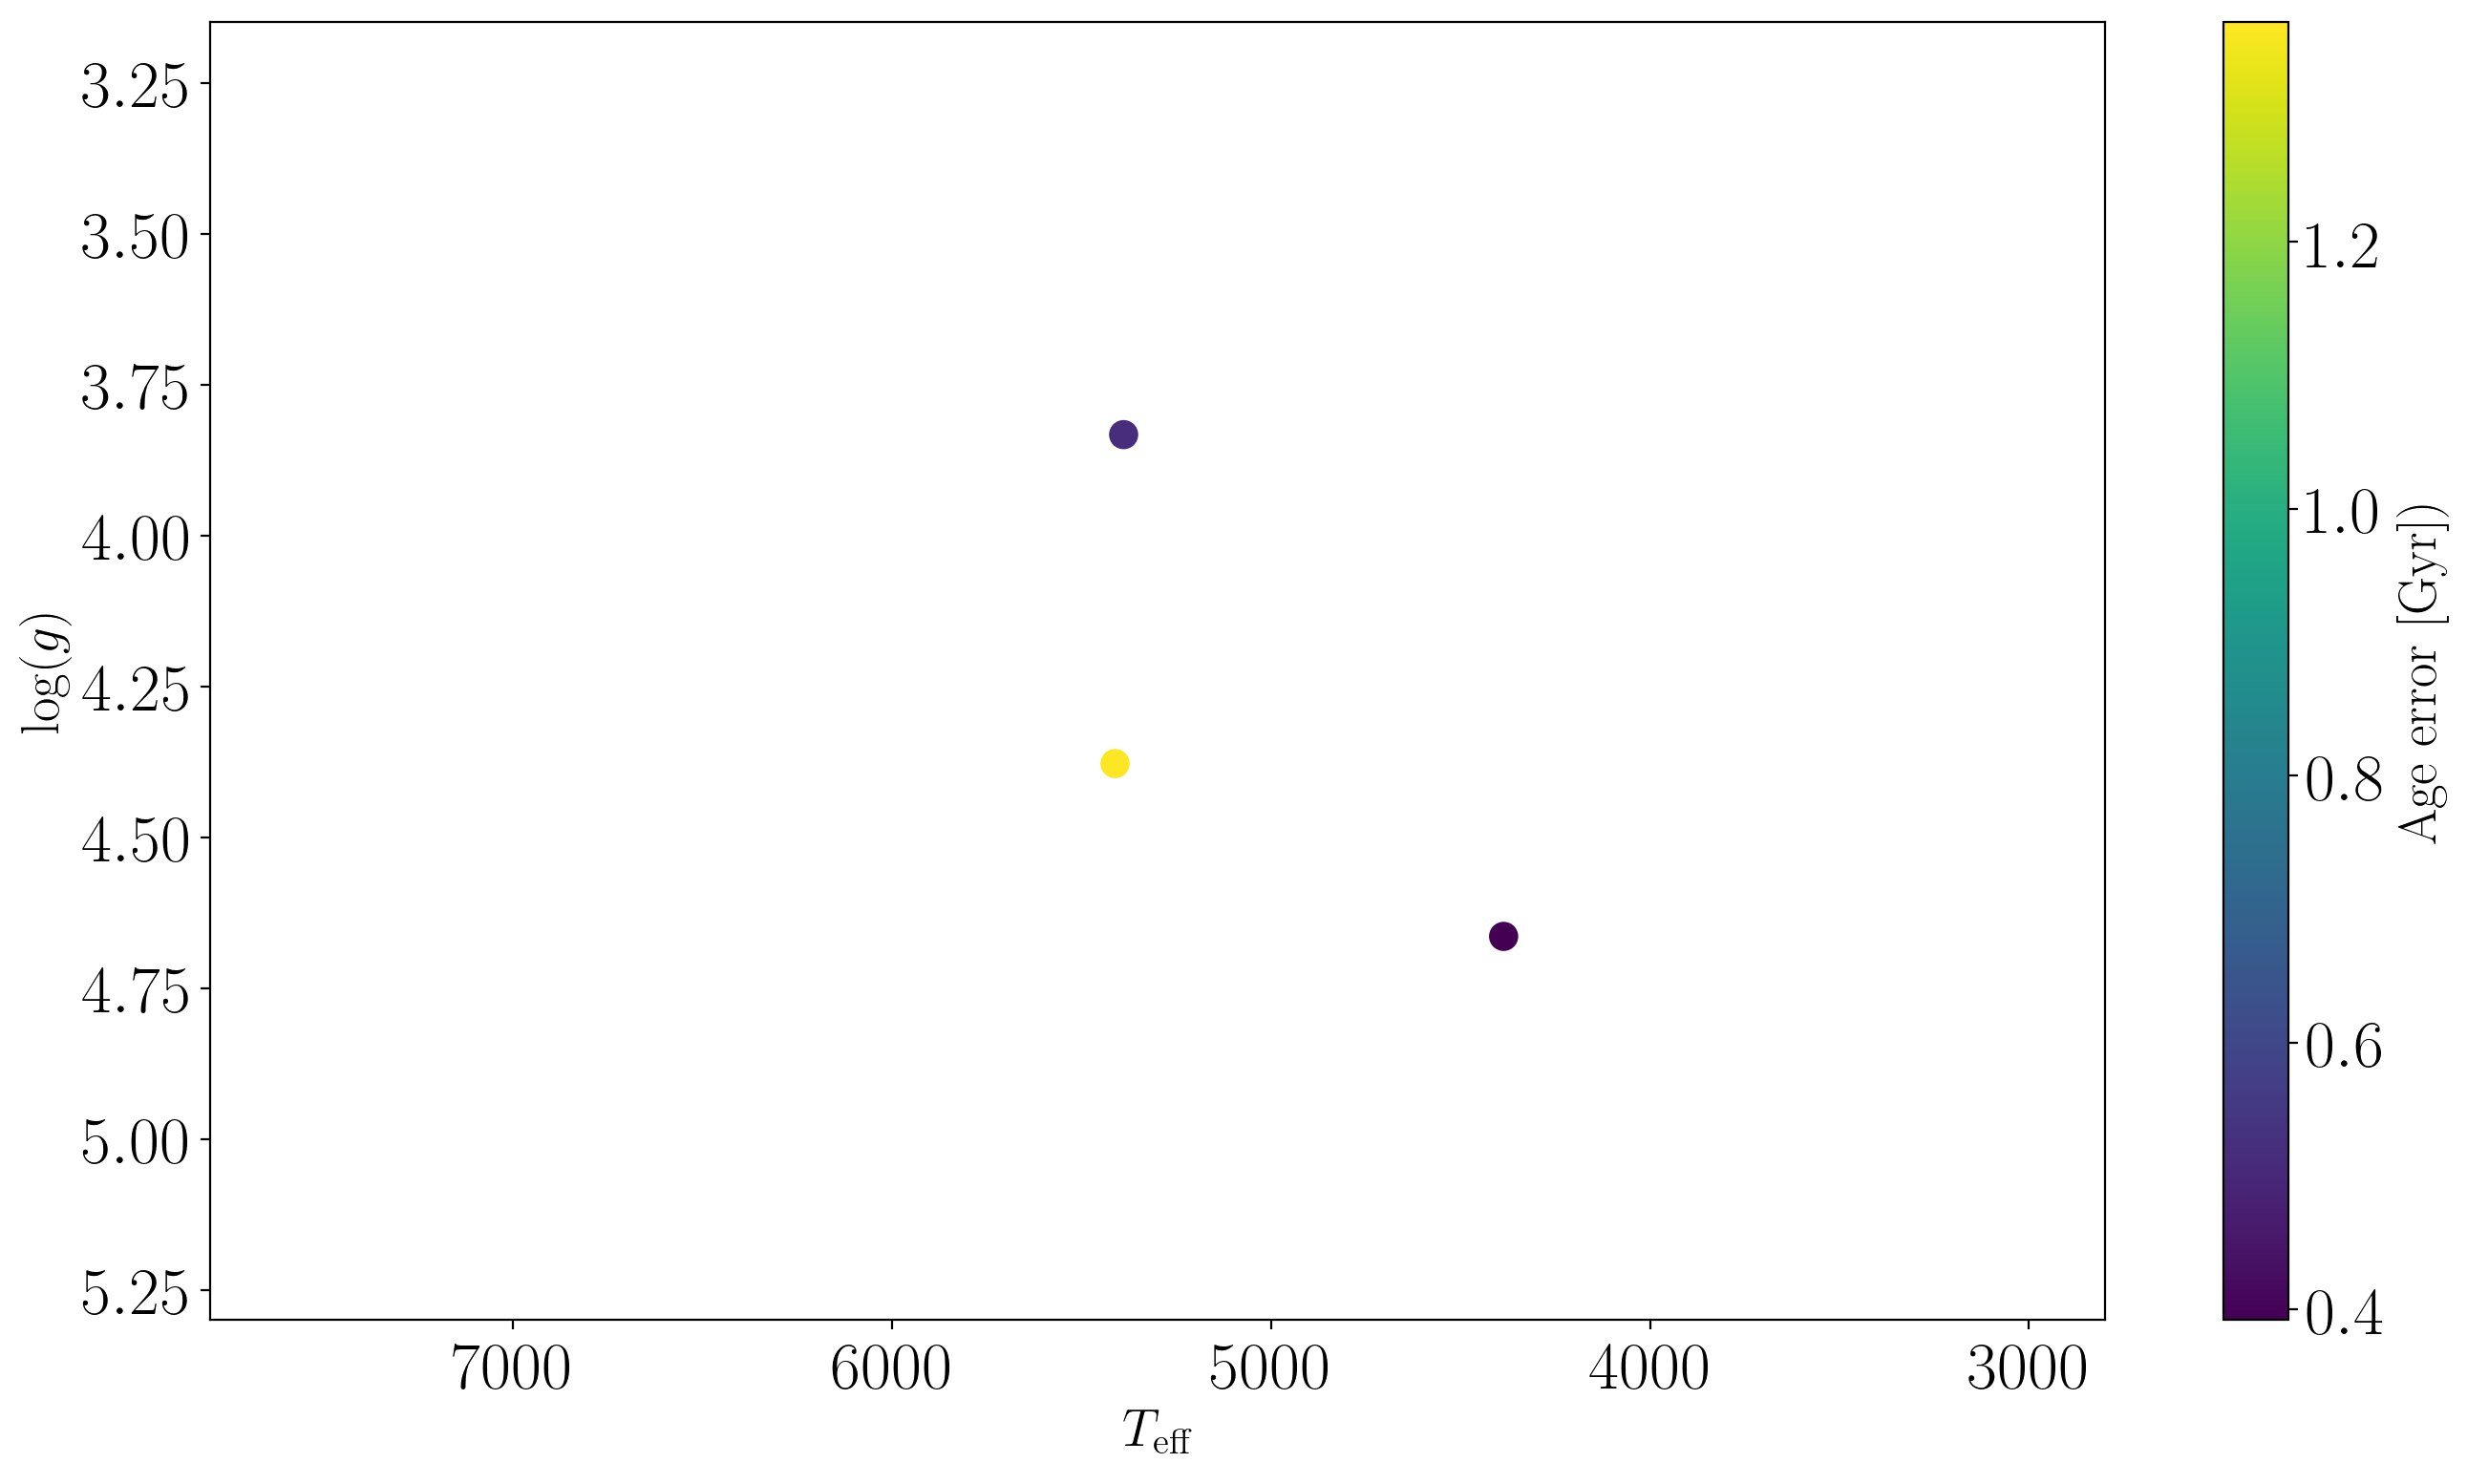

In [123]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff.values[:N], df.logg.values[:N], c=abs(true_age_gyr[:N] - meds), s=100)
plt.colorbar(label="$\mathrm{Age~error~[Gyr]})$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

Now just the isochrone model.

In [126]:
meds_iso, stds_iso, age_samps_iso, resids_iso, errp_iso, errm_iso = [], [], [], [], [], []
eeps_iso, eep_errp_iso, eep_errm_iso = [], [], []
N_iso = 1

burnin = 1

for i in range(N_iso):
    fname = "{0}_isochrones.h5".format(savedir, str(i).zfill(4))
    reader = emcee.backends.HDFBackend(fname)
    samples_iso = reader.get_chain()
    nsteps, nwalkers, ndim = np.shape(samples_iso)
    
    samps_iso = np.reshape(samples_iso[burnin:, :, :], (nwalkers*(nsteps - burnin), ndim))
    age_samps_iso.append((10**samps_iso[:, 1])*1e-9)
    resids_iso.append(list(np.array(age_samps_iso[i]) - true_age_gyr[i]))
    meds_iso.append(np.median(age_samps_iso[i]))
    stds_iso.append(np.std(age_samps_iso[i]))
    upper_iso = np.percentile(age_samps_iso[i], 84)
    lower_iso = np.percentile(age_samps_iso[i], 16)
    errp_iso.append(upper_iso-meds_iso[i])
    errm_iso.append(meds_iso[i]-lower_iso)
    
    eep_samps_iso = samps_iso[:, 0]
    eeps_iso.append(np.median(eep_samps_iso))
    upper_iso = np.percentile(age_samps_iso[i], 84)
    lower_iso = np.percentile(age_samps_iso[i], 16)
    eep_errp_iso.append(upper_iso-meds_iso[i])
    eep_errm_iso.append(meds_iso[i]-lower_iso)
meds_iso, stds_iso, errp_iso, errm_iso = np.array(meds_iso), np.array(stds_iso), np.array(errp_iso), np.array(errm_iso)

AttributeError: You must run the sampler with 'store == True' before accessing the results

(200, 500)

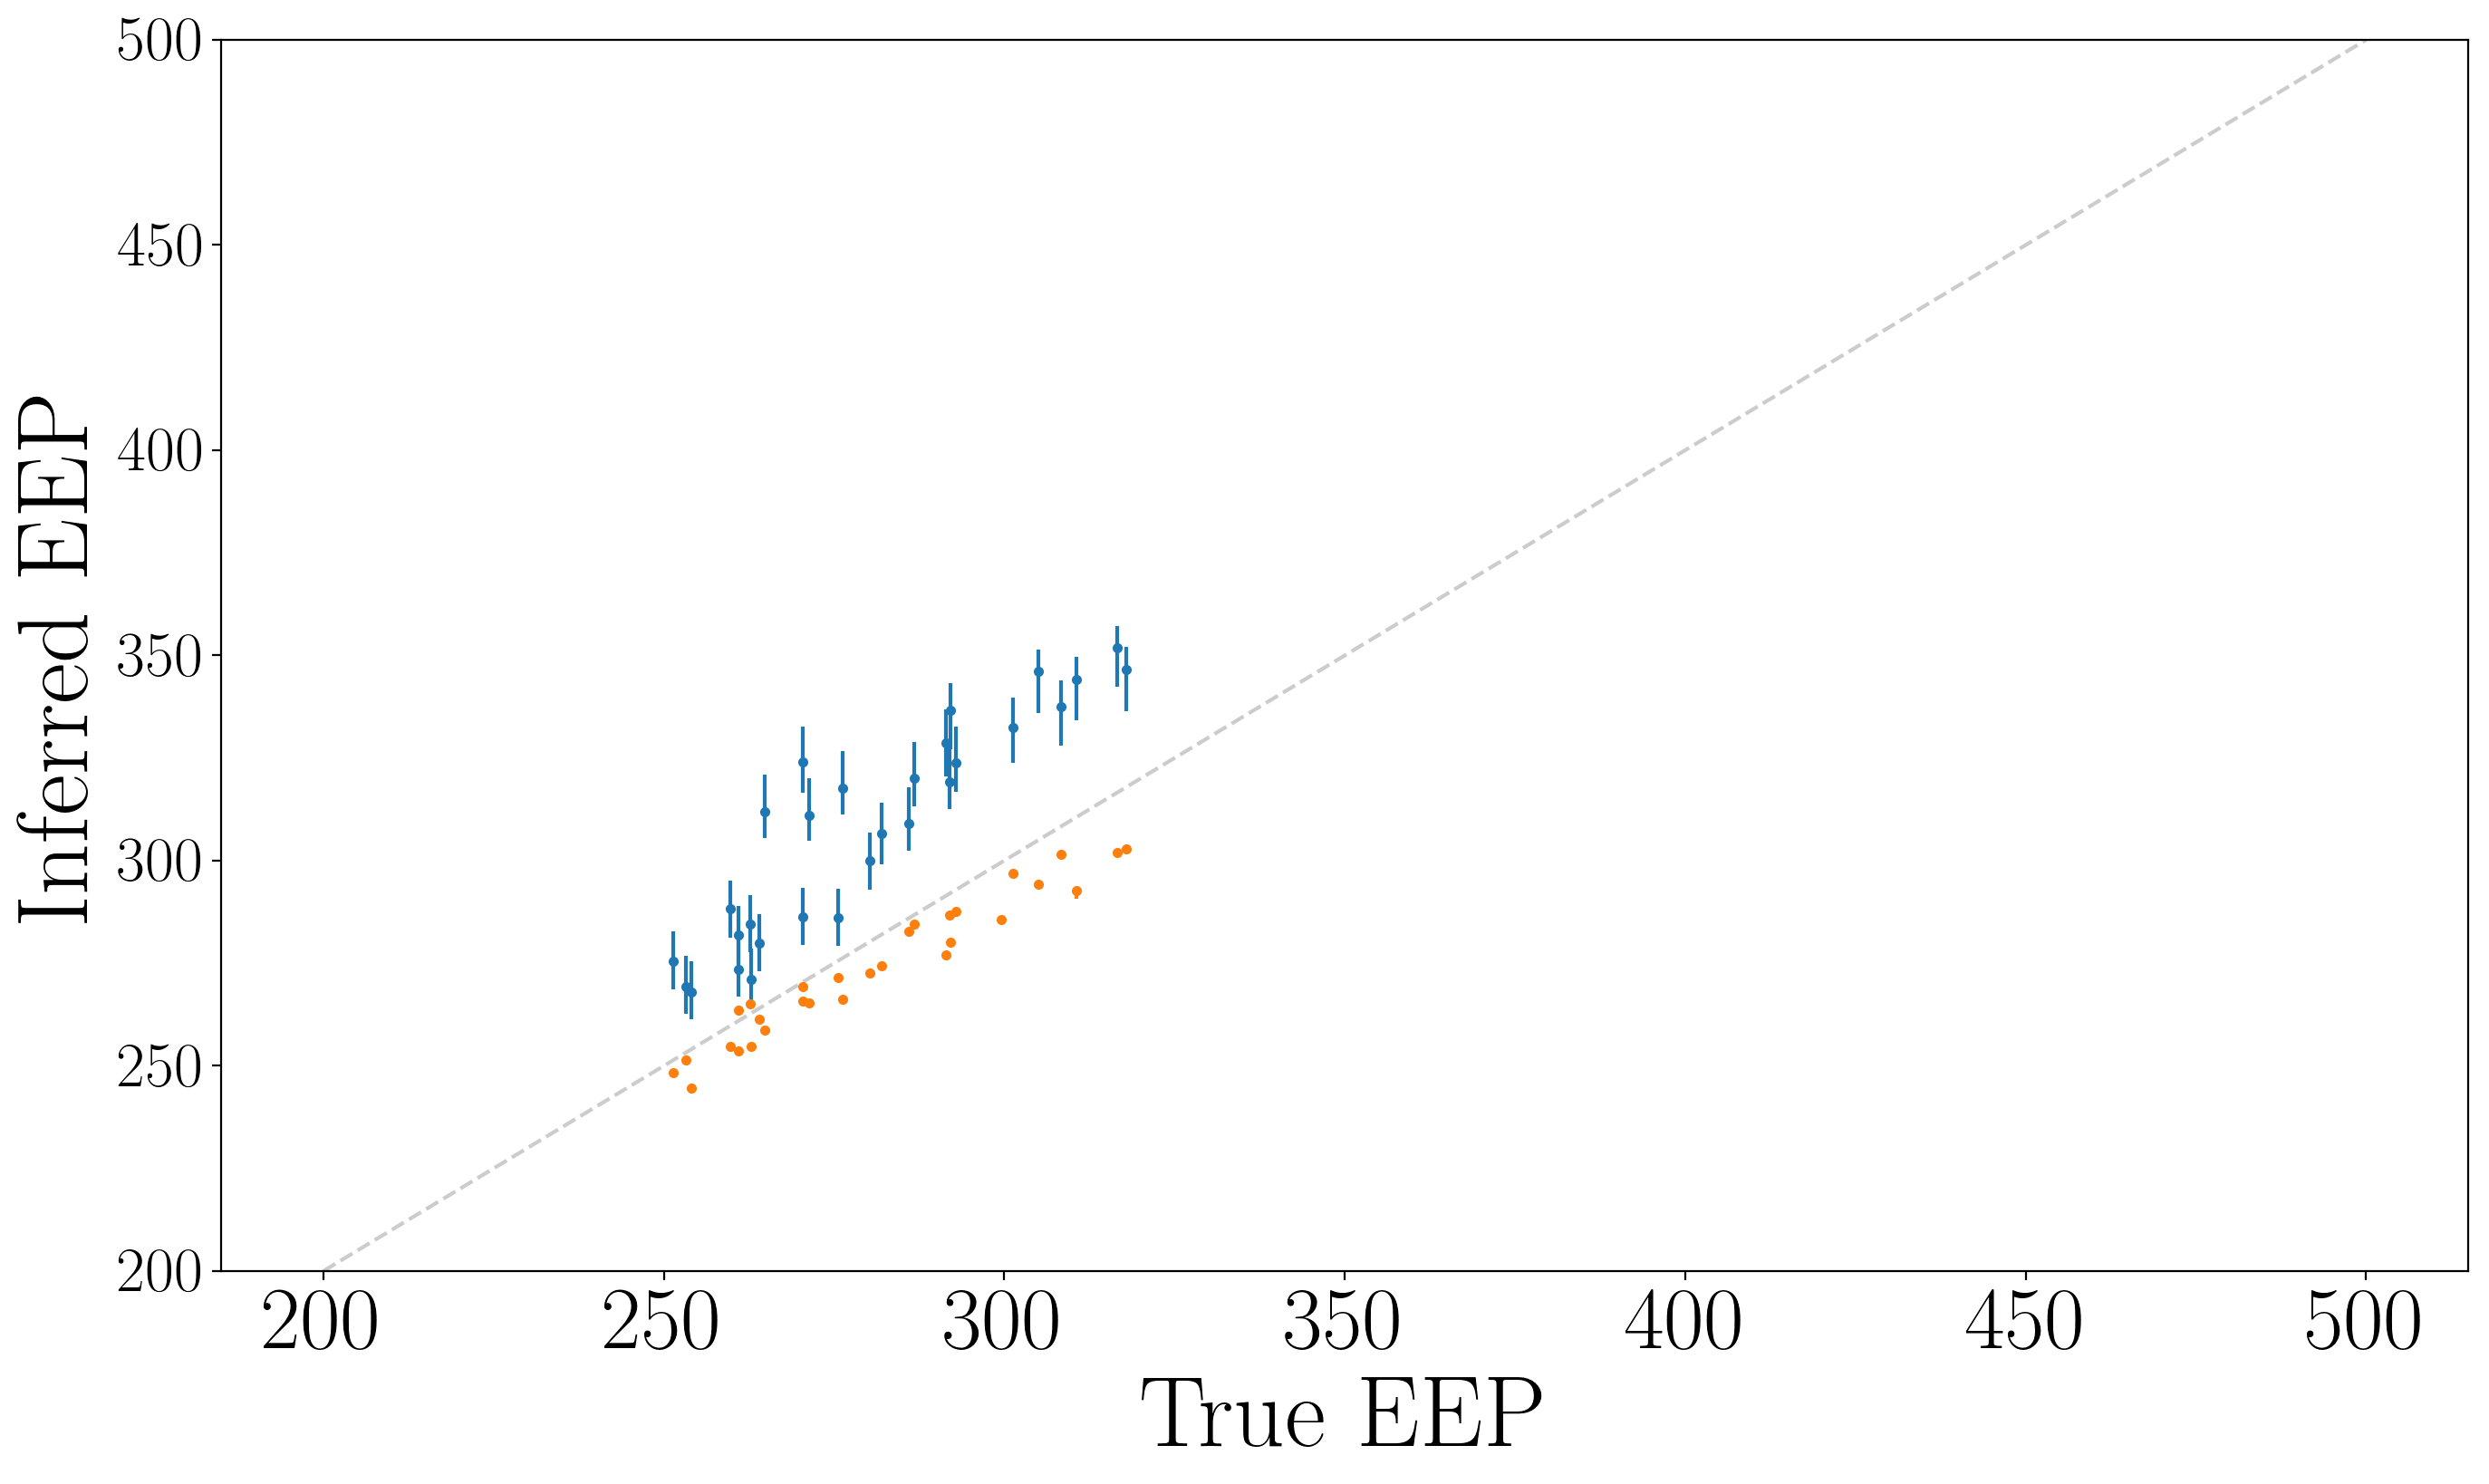

In [319]:
plt.figure(figsize=(16, 9), dpi=200)
plt.errorbar(df.eep.values[:N_iso], eeps_iso, yerr=[eep_errm_iso, eep_errp_iso], fmt=".", zorder=0)
plt.errorbar(df.eep.values[:N], eeps, yerr=[eep_errm, eep_errp], fmt=".", zorder=0)
plt.xlabel("$\mathrm{True~EEP}$")
plt.ylabel("$\mathrm{Inferred~EEP}$")
eep_xs = np.linspace(200, 500, 100)
plt.plot(eep_xs, eep_xs, ".5", ls="--", alpha=.4)
plt.ylim(200, 500)

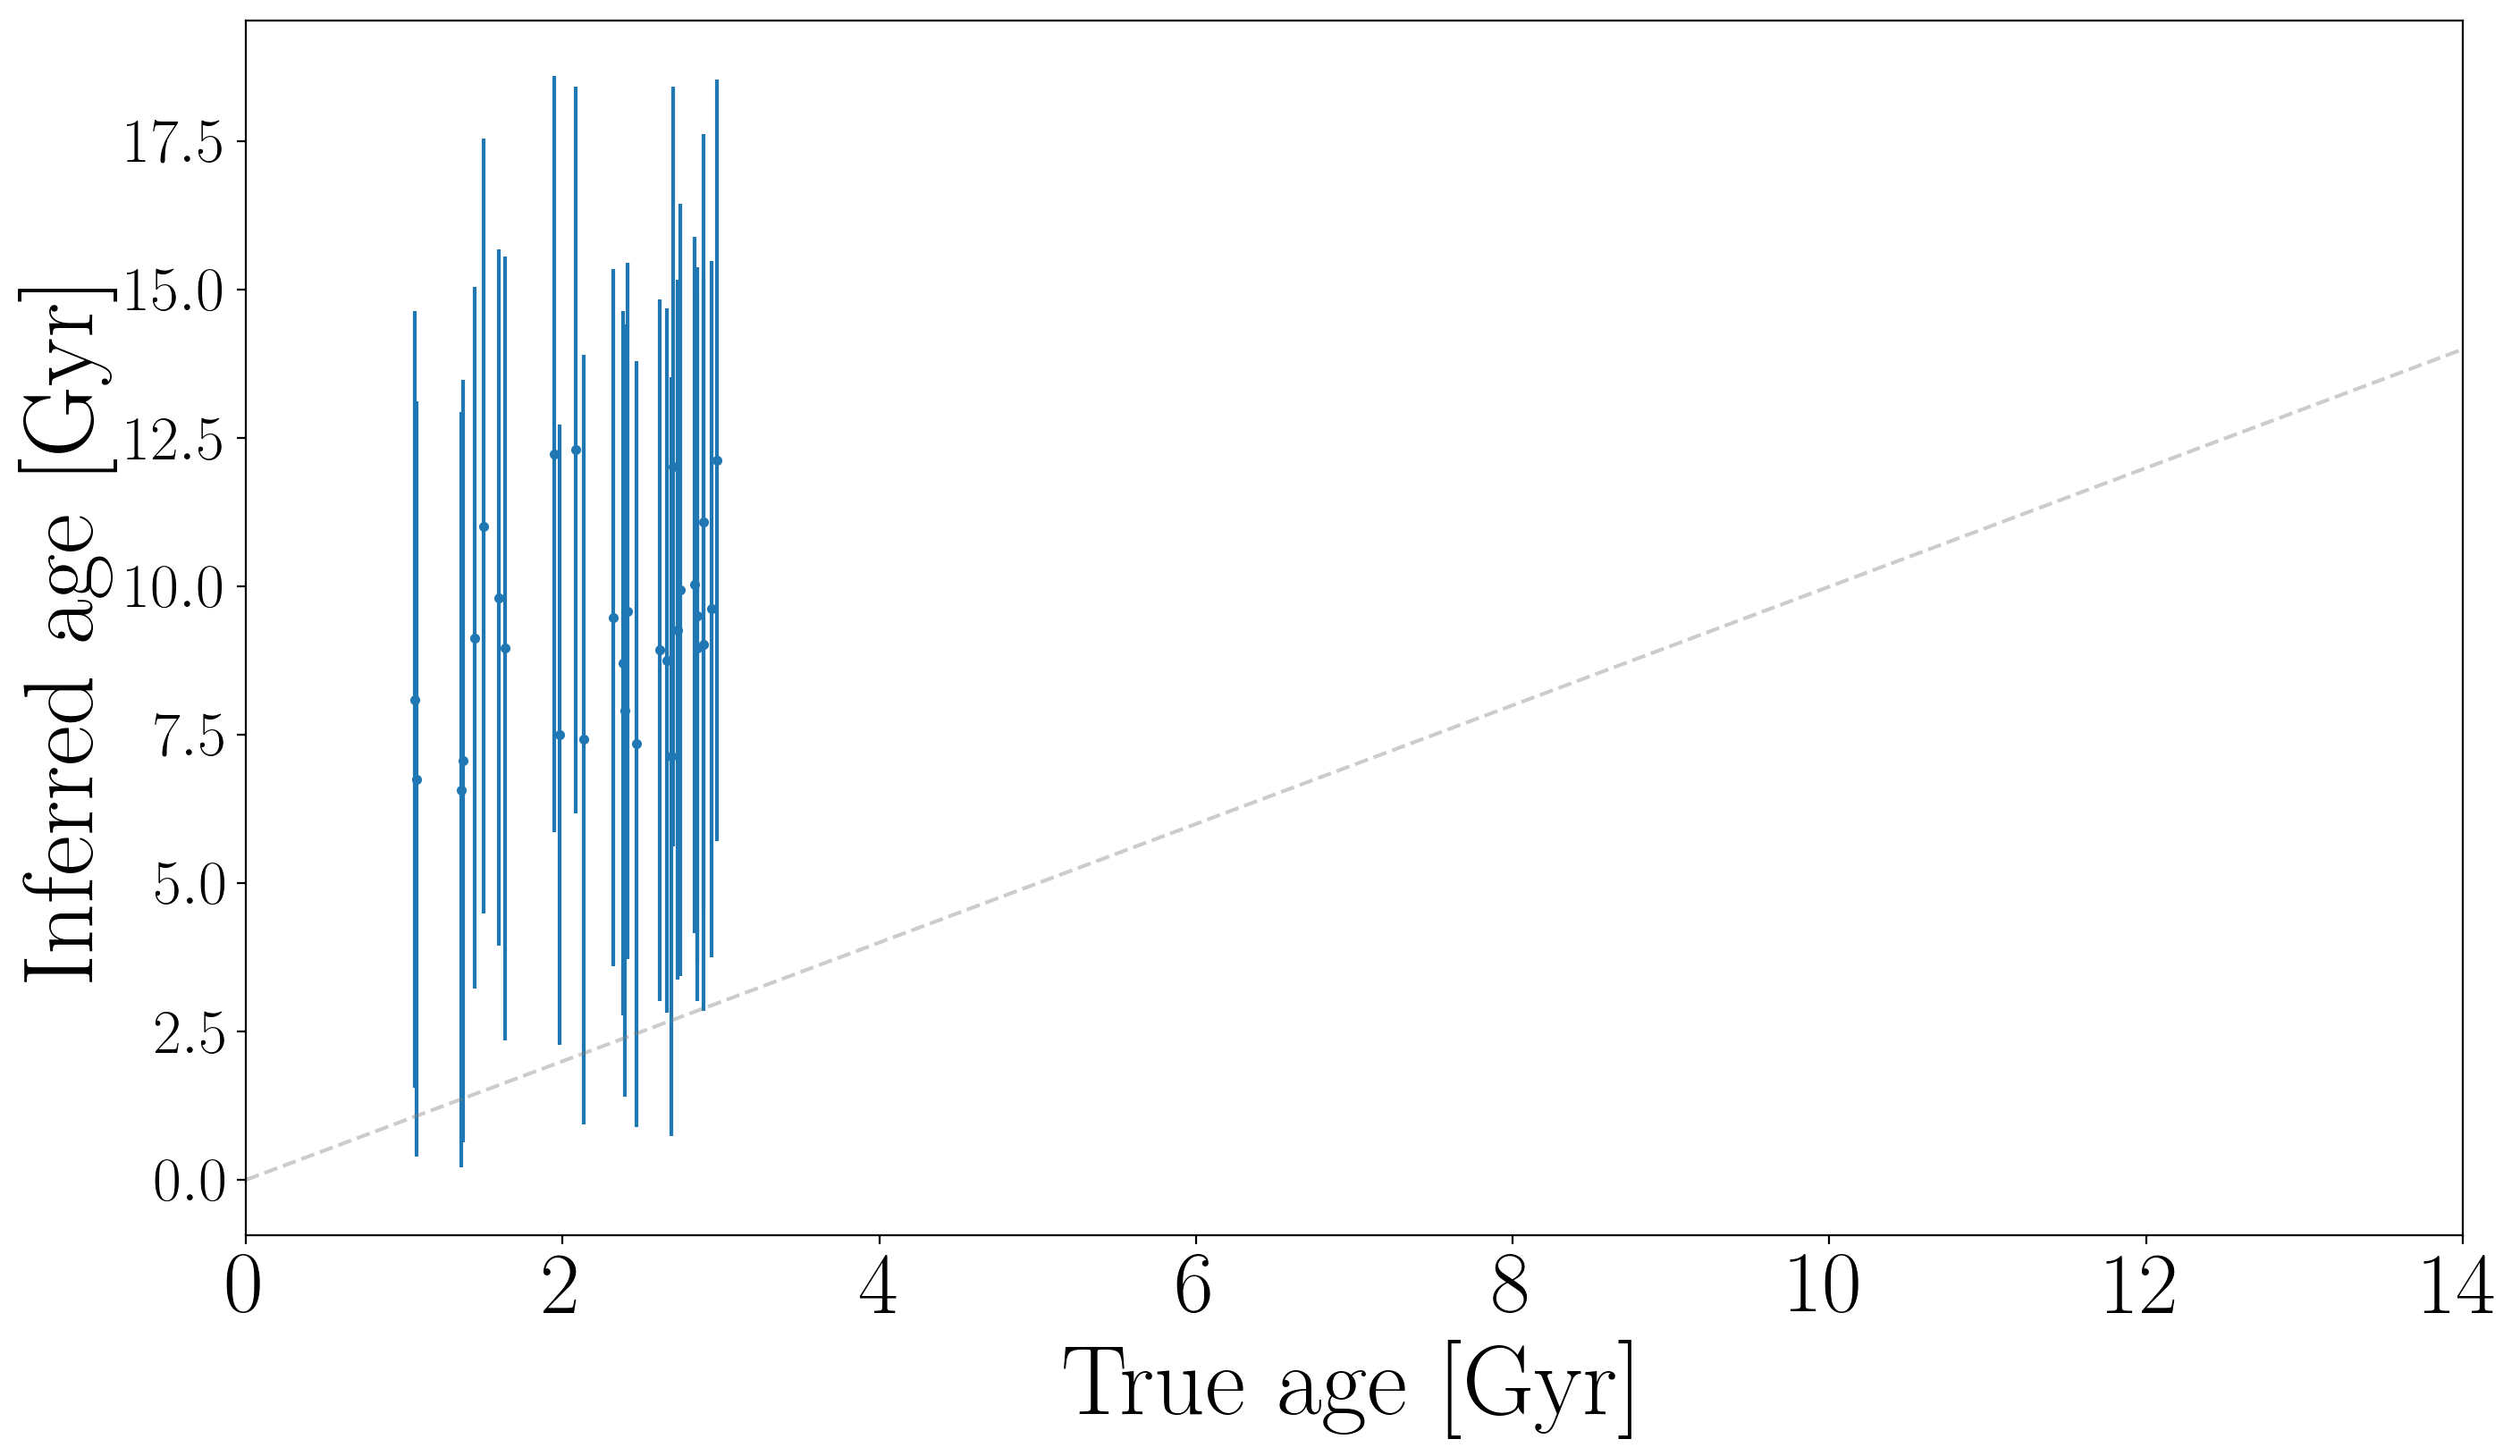

In [315]:
plt.figure(figsize=(16, 9), dpi=200)
# plt.errorbar((10**df.age.values[:N_iso])*1e-9, meds_iso, yerr=stds_iso, fmt=".")
plt.errorbar((10**df.age.values[:N_iso])*1e-9, meds_iso, yerr=stds_iso, fmt=".")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.savefig("iso_only.pdf")

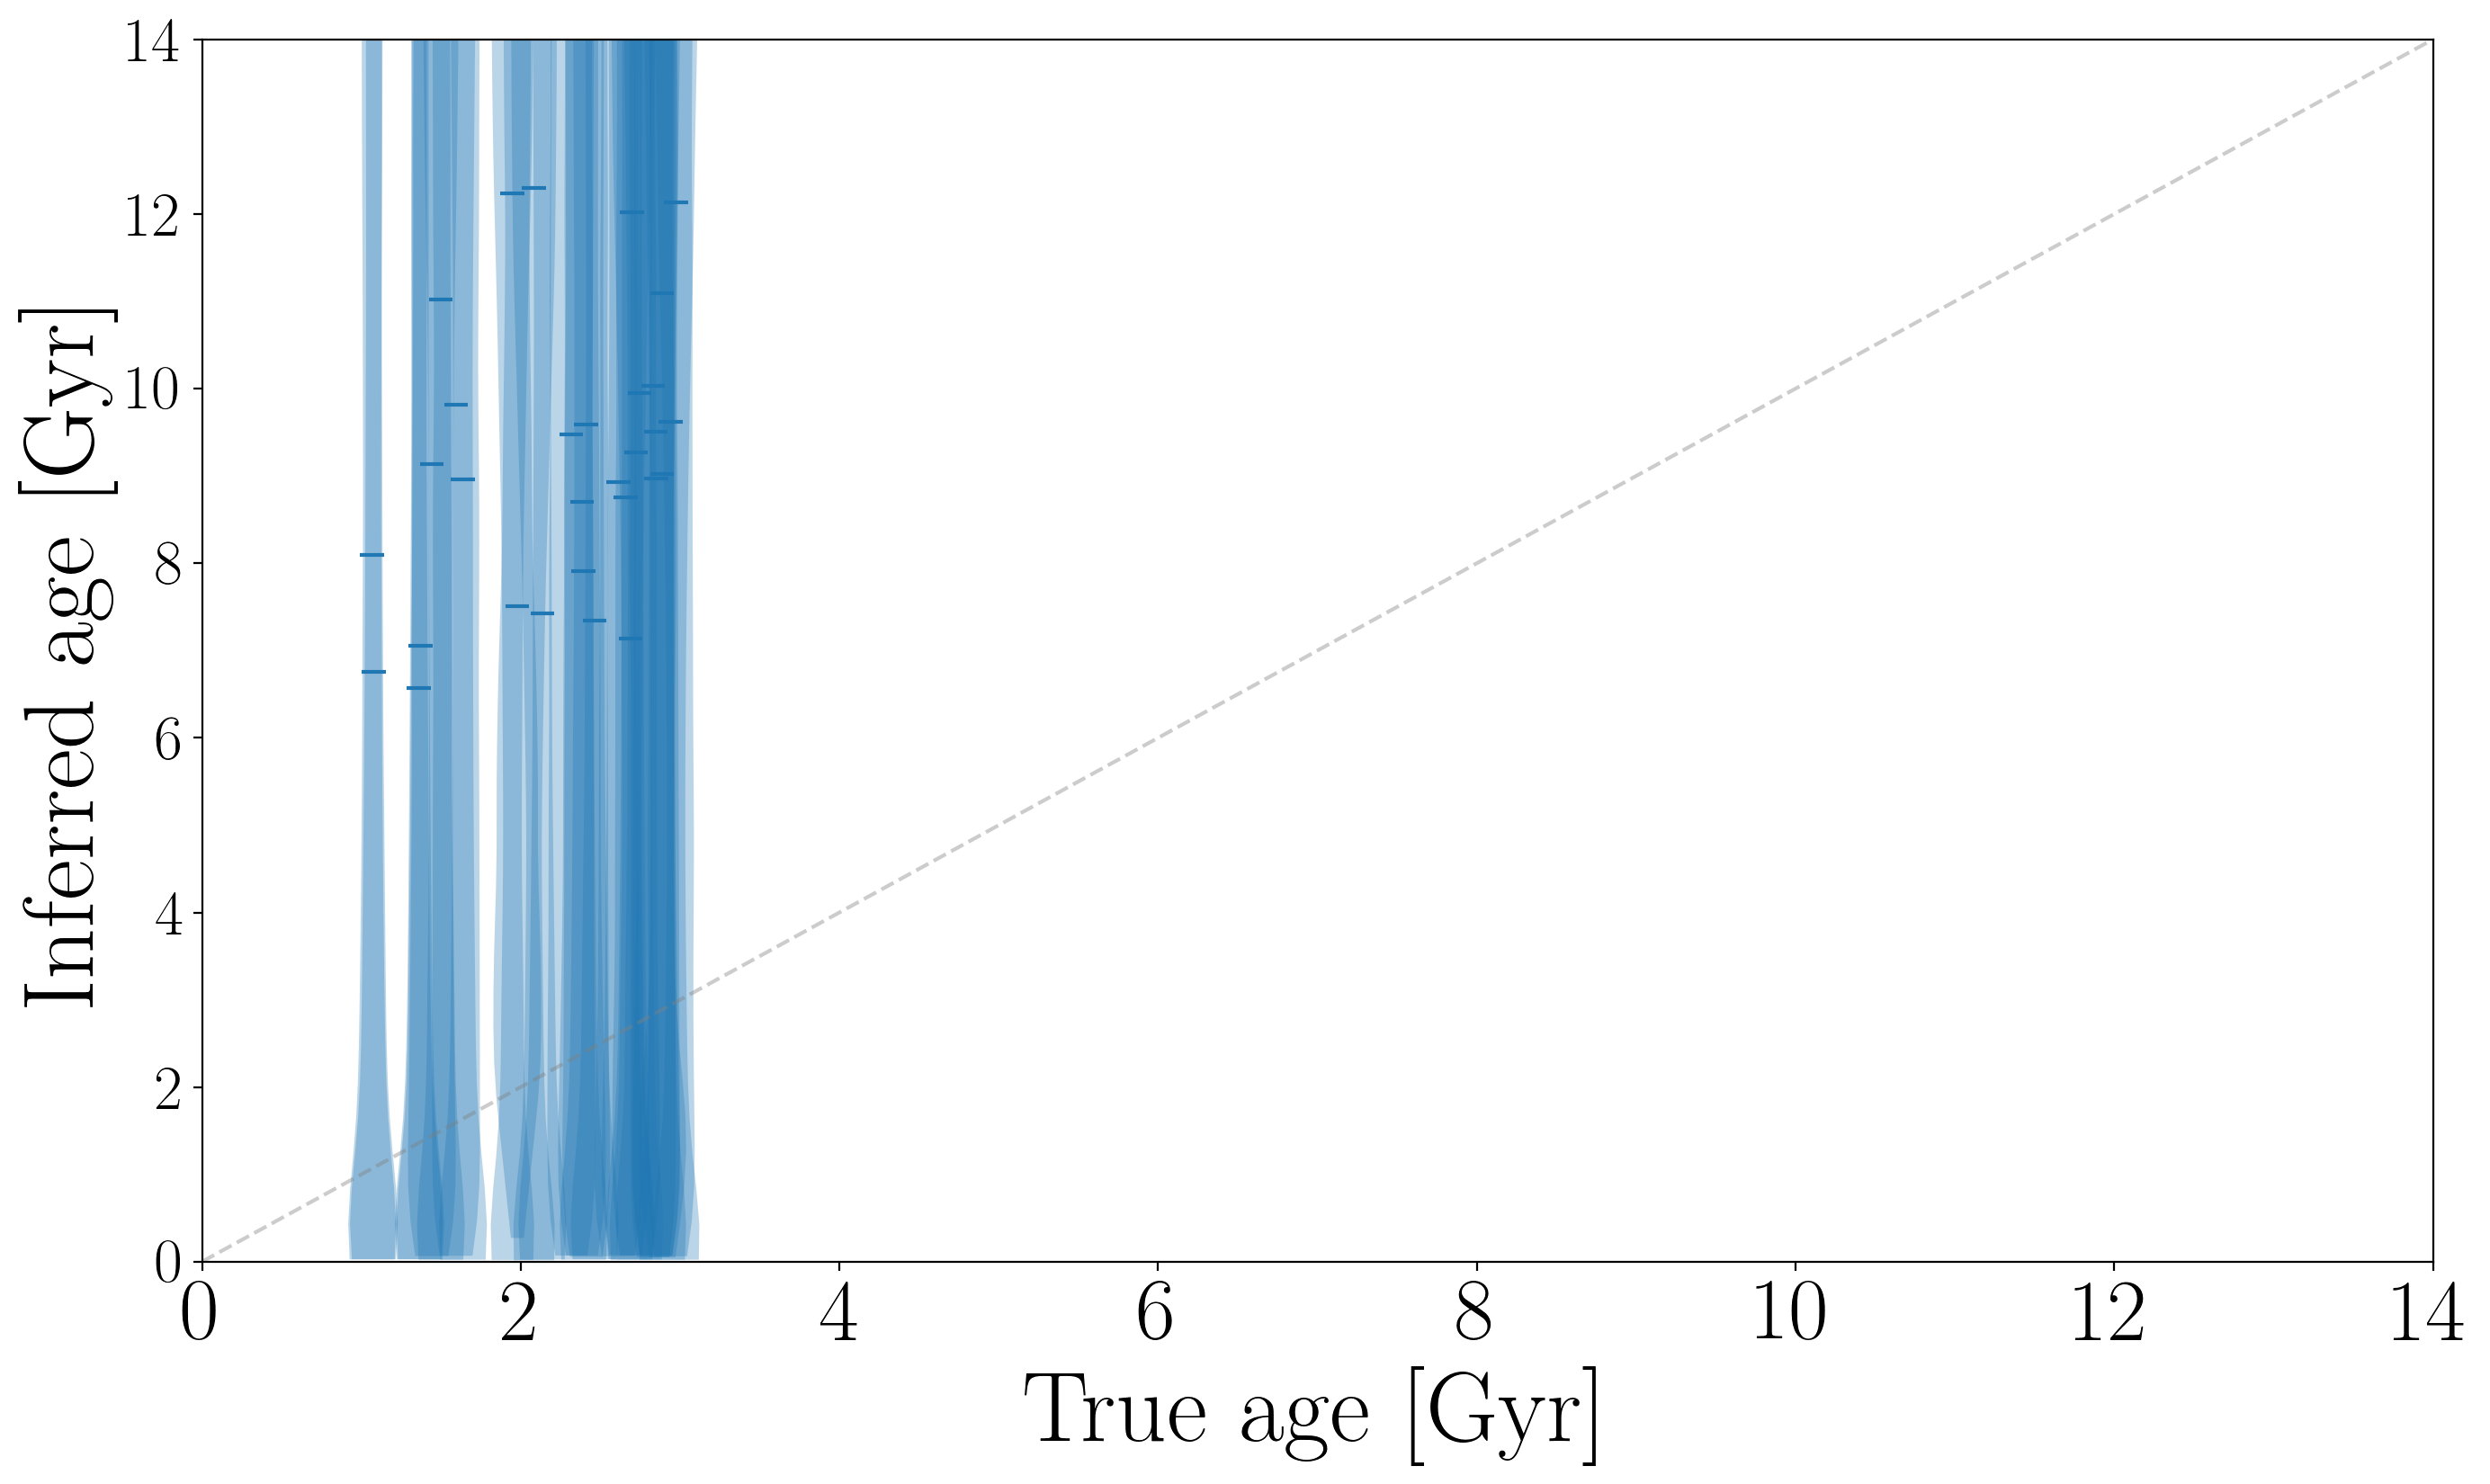

In [316]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 9), dpi=200)
mm = m[:N_iso]
axes.violinplot(age_samps_iso, true_age_gyr[:N_iso], points=50, widths=0.3,
                showmeans=False, showextrema=False, showmedians=True)
# axes.violinplot(age_samps_iso[mm], true_age_gyr[:N_iso][mm], points=50, widths=0.3, color="tab:orange",
#                 showmeans=False, showextrema=False, showmedians=False)
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)
plt.ylim(0, 14)
plt.savefig("iso_only_violin.pdf")

Text(0,0.5,'$\\log(g)$')

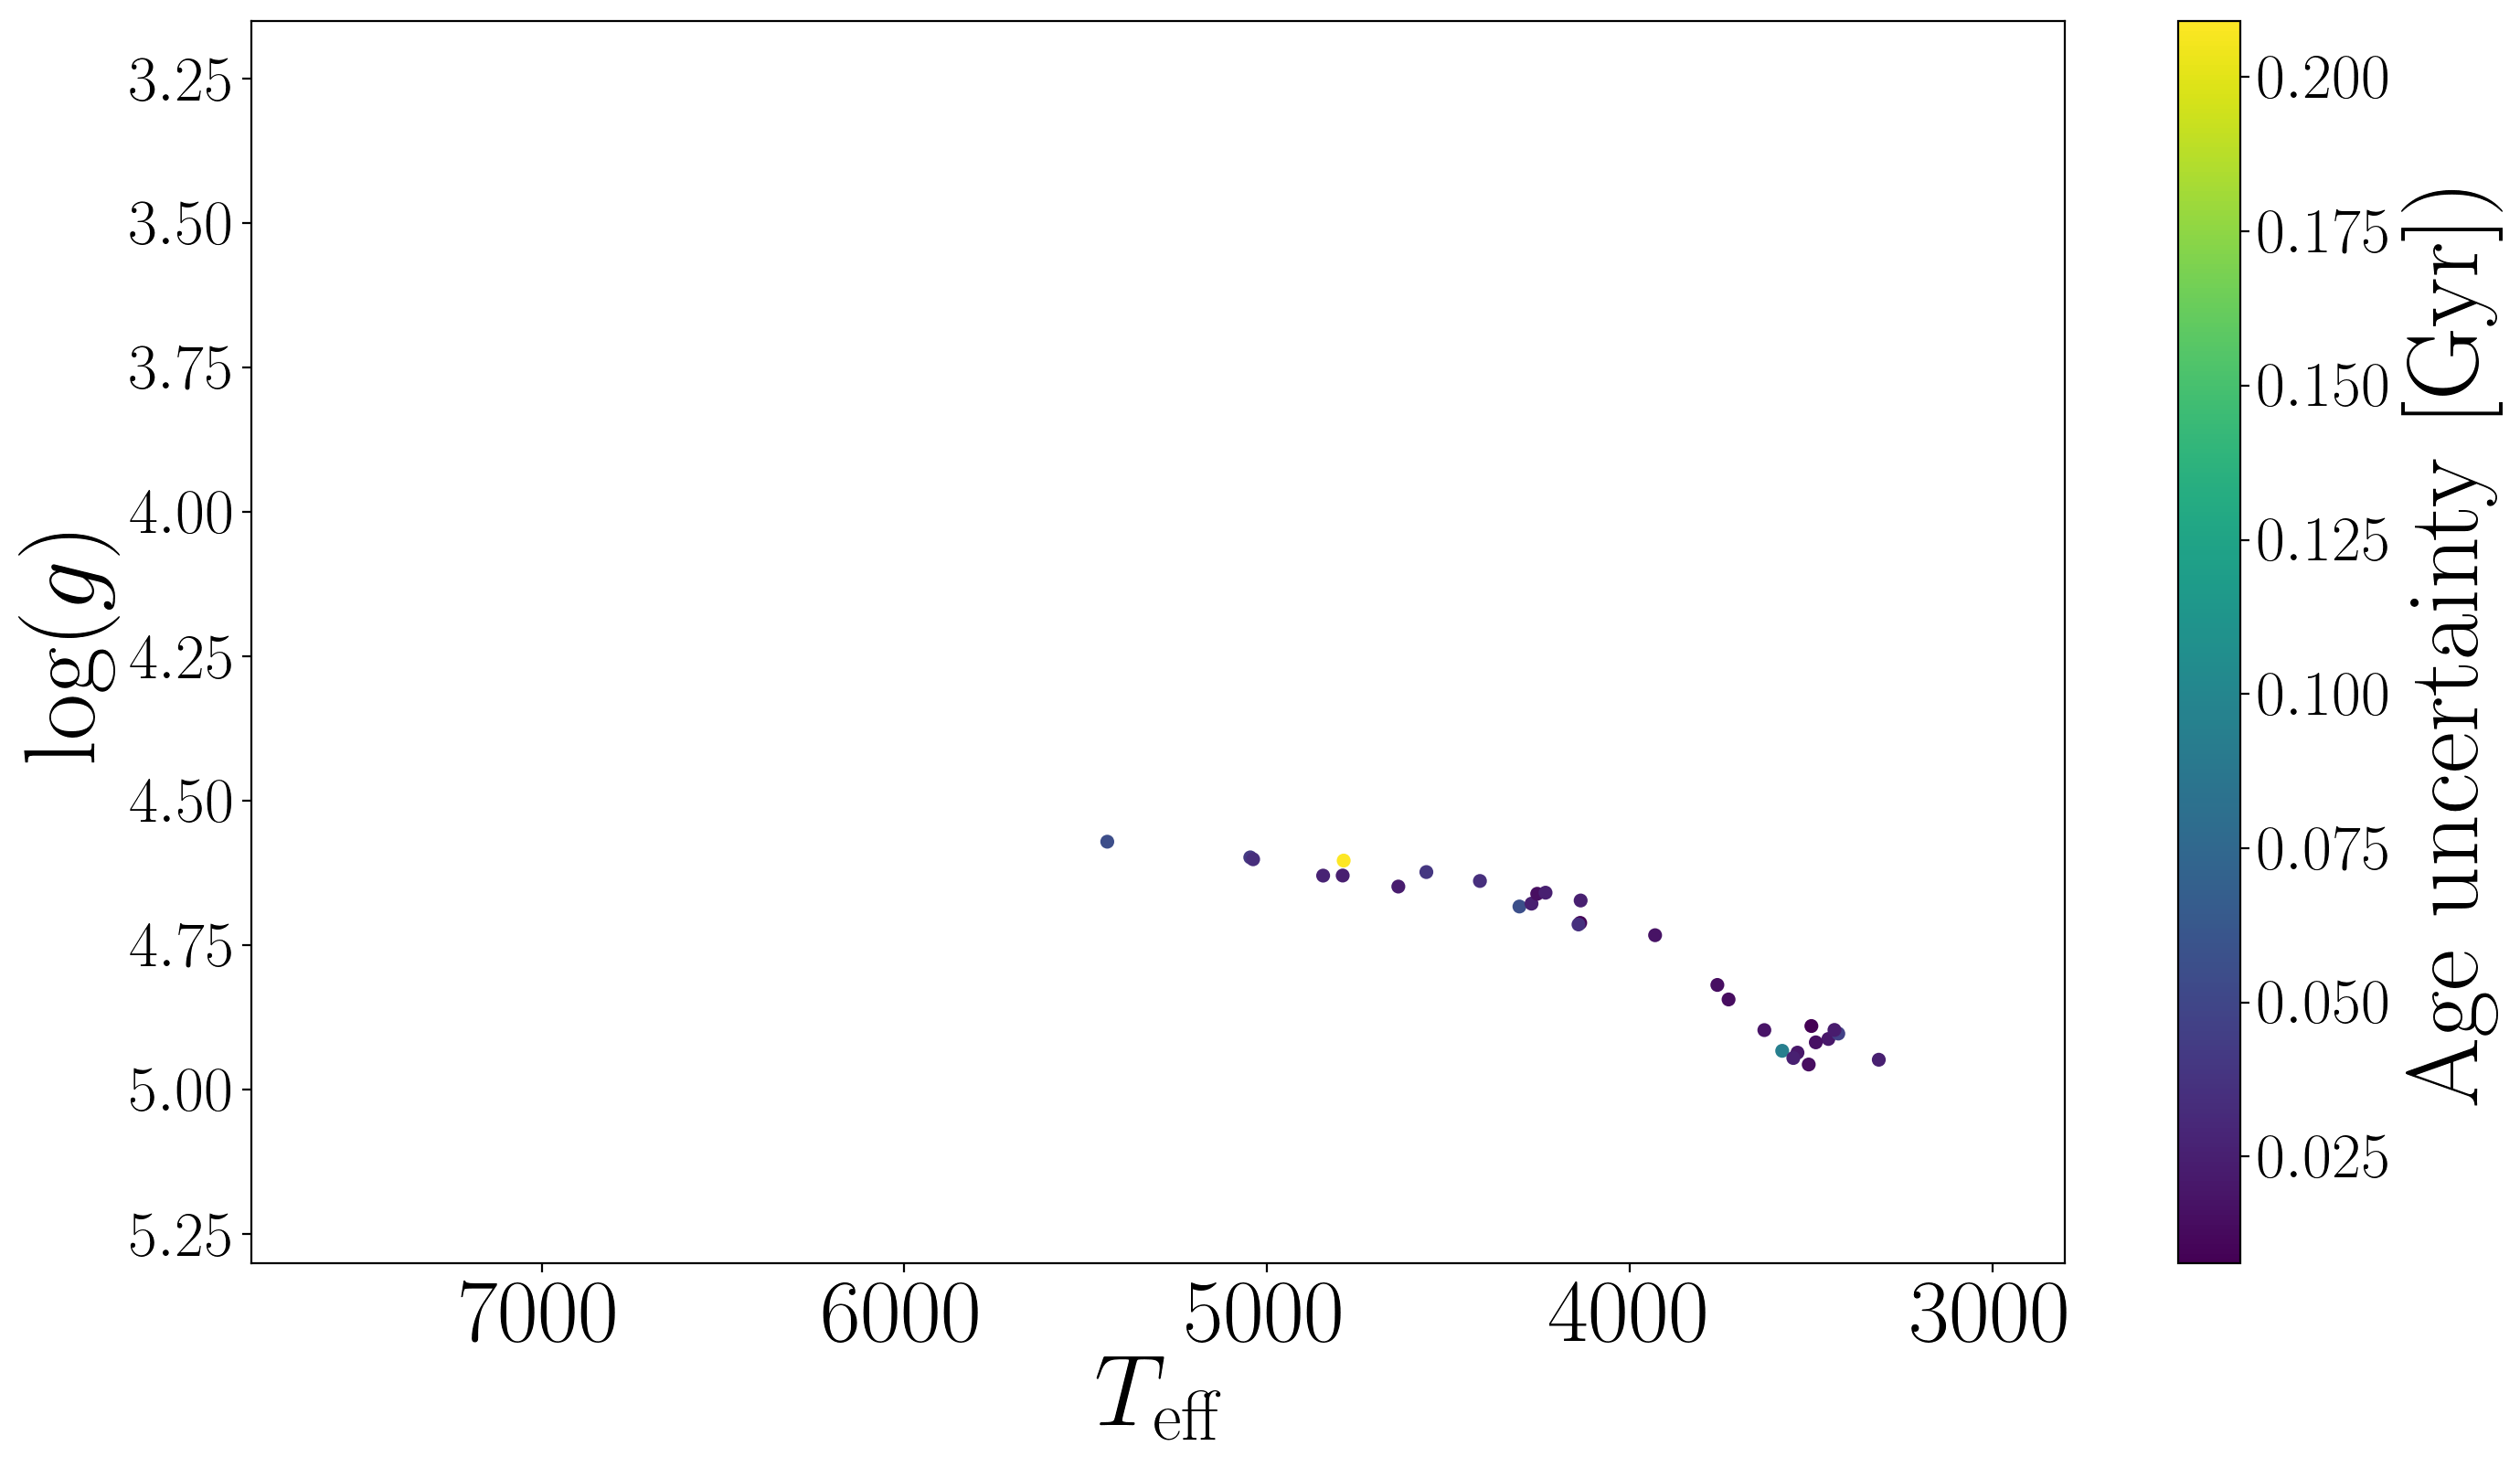

In [317]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff.values[:N], df.logg.values[:N], c=stds/df.age.values[:N], s=20)
plt.colorbar(label="$\mathrm{Age~uncertainty~[Gyr]})$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

Text(0,0.5,'$\\log(g)$')

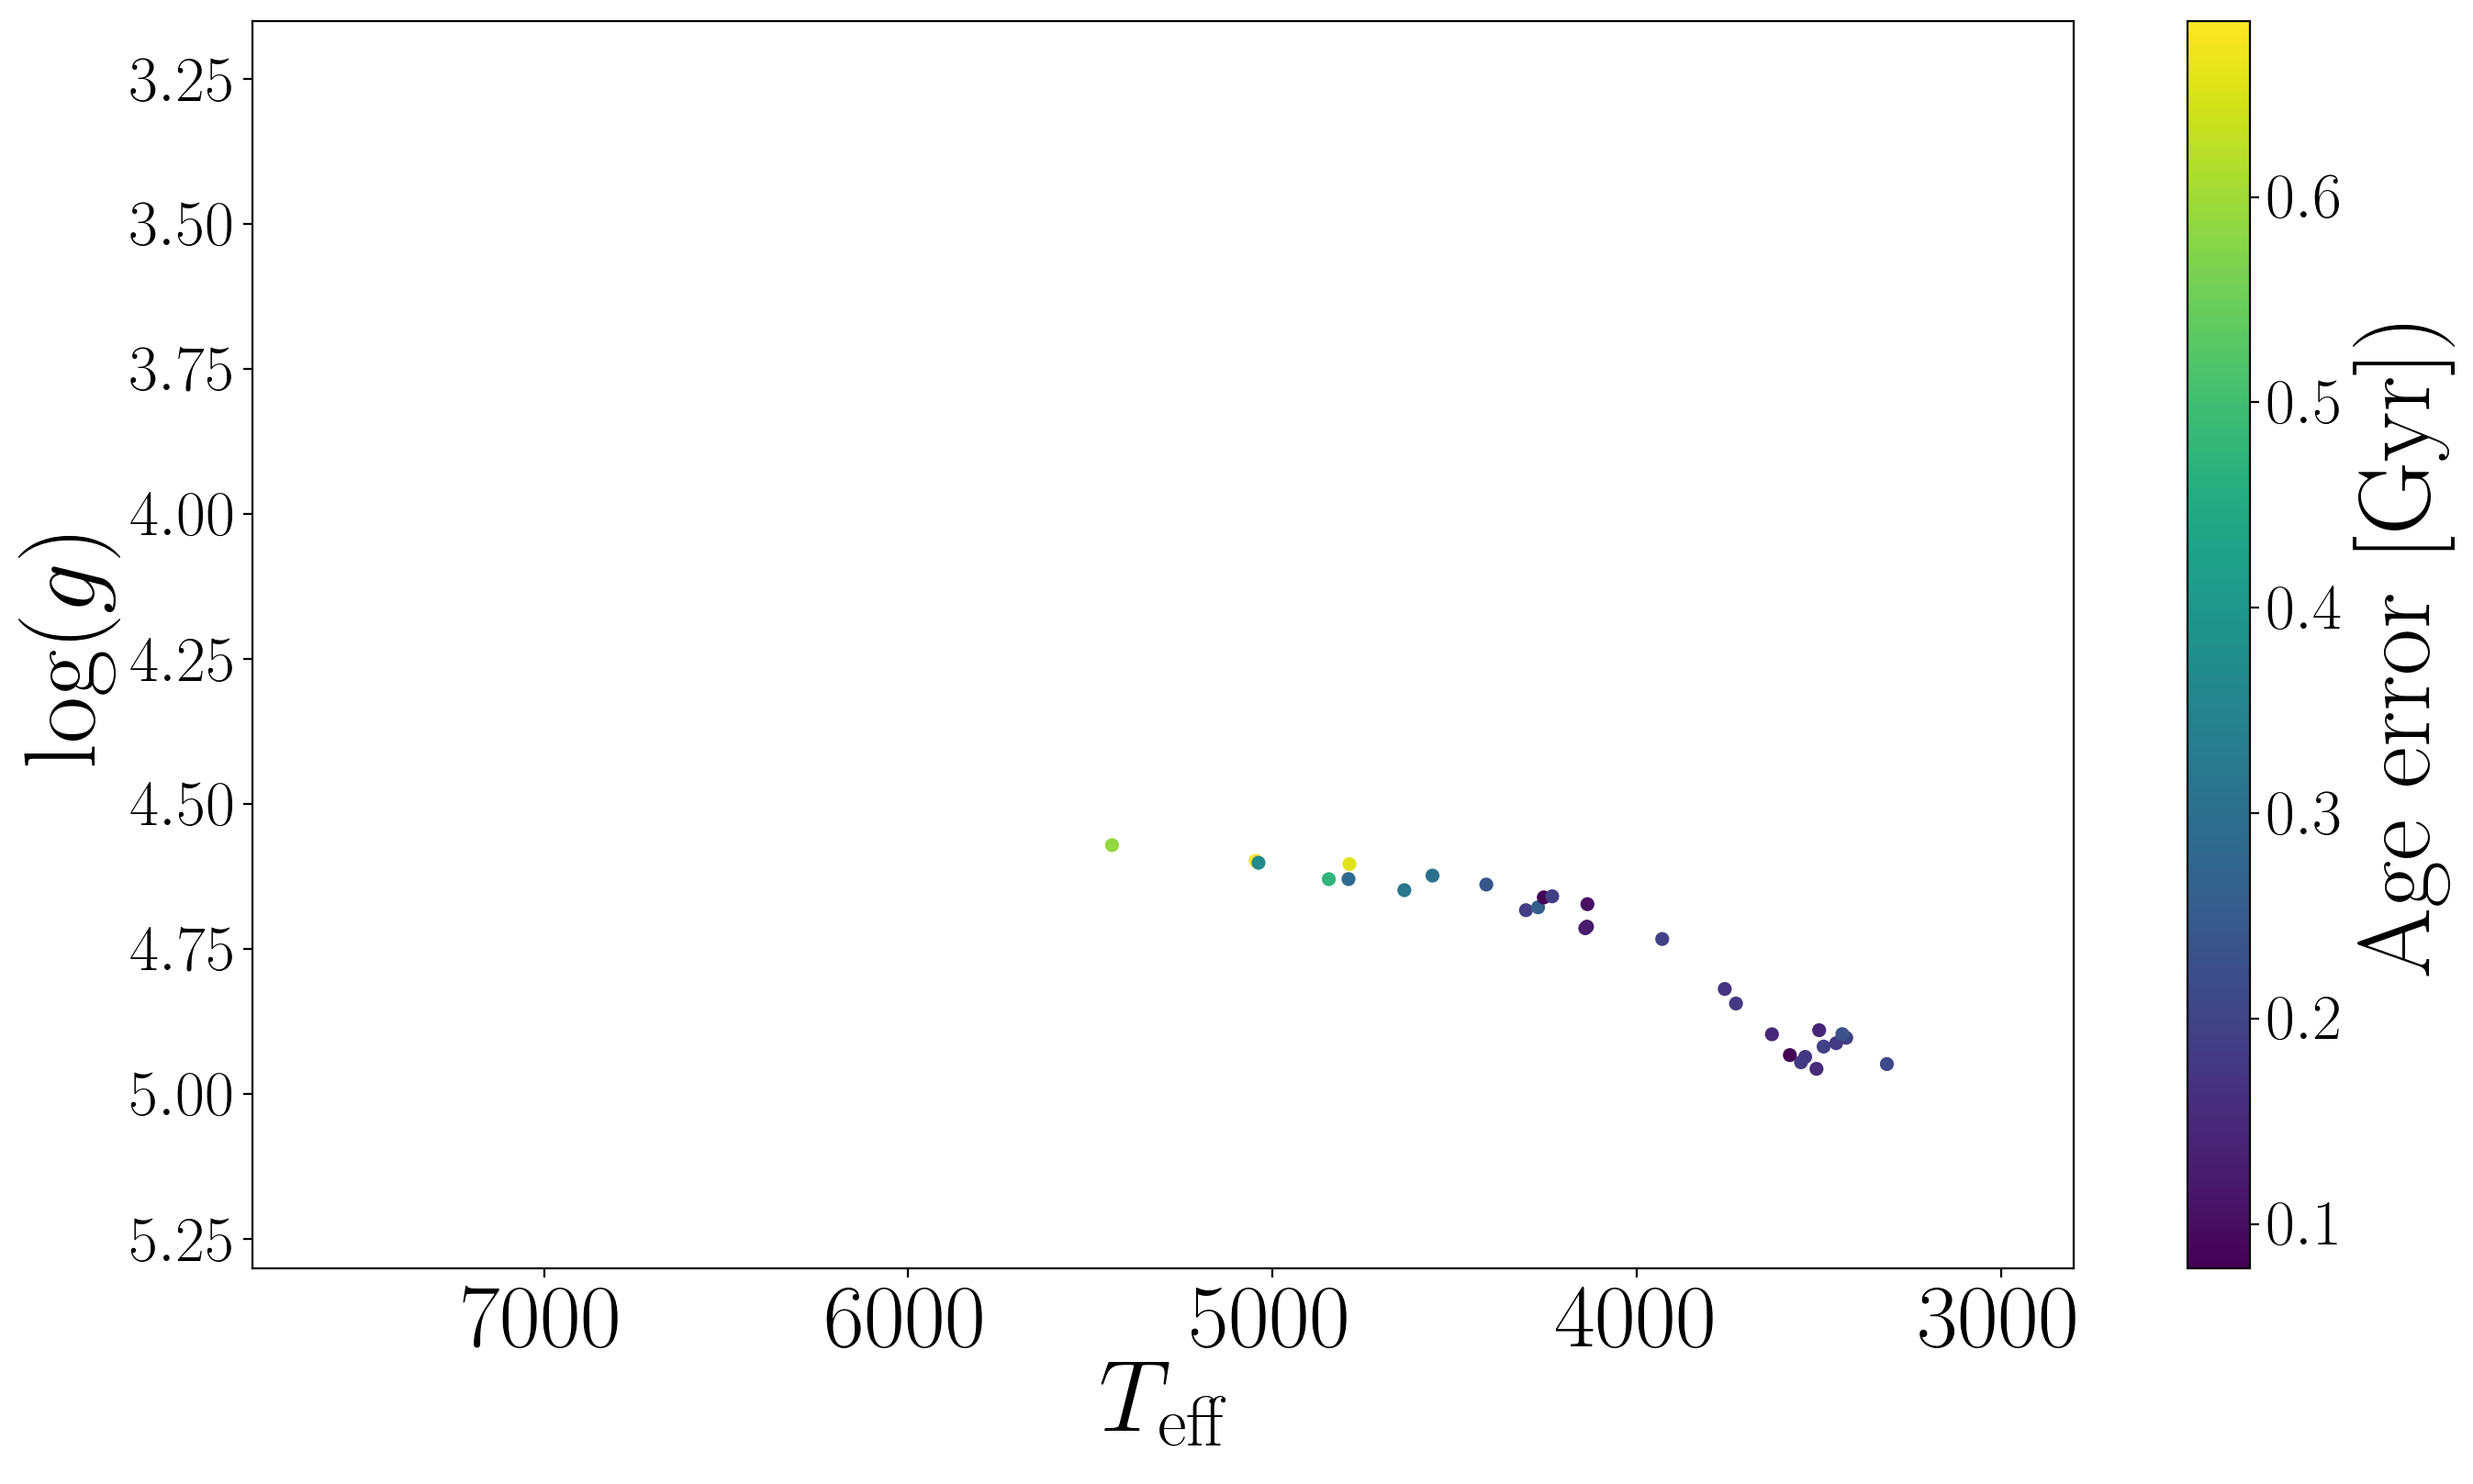

In [318]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff.values[:N], df.logg.values[:N], c=abs(true_age_gyr[:N] - meds), s=20)
plt.colorbar(label="$\mathrm{Age~error~[Gyr]})$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

Now just the gyrochronology model.

In [12]:
savedir = "simulation_results/gyro_only"
meds_gyro, stds_gyro = [], []
N = 80
for i in range(N):
    with h5py.File("{0}/{1}.h5".format(savedir, str(i).zfill(4)), "r") as f:
            samples = f["samples"][...]
            age_samps = (10**samples[:, 1])*1e-9
            meds_gyro.append(np.median(age_samps))
            stds_gyro.append(np.std(age_samps))

OSError: Unable to open file (Unable to open file: name = 'simulation_results/gyro_only/0000.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [ ]:
plt.figure(figsize=(16, 9))
plt.errorbar((10**df.age.values[:N])*1e-9, meds_gyro, yerr=stds_gyro, fmt=".")
plt.xlabel("$\mathrm{True~age~[Gyr]}$")
plt.ylabel("$\mathrm{Inferred~age~[Gyr]}$")
xs = np.linspace(0, 14, 100)
plt.plot(xs, xs, ".5", ls="--", alpha=.4)
plt.xlim(0, 14)

# Now load results from Cluster runs.

In [ ]:
savedir = "cluster_results/iso_and_gyro"
meds, stds, age_samps, resids, errp, errm = [], [], [], [], [], []
mass_samps, feh_samps, dist_samps, av_samps = [], [], [], []
N = 19

for i in trange(N):
    fname = "{0}/{1}_samples.h5".format(savedir, str(i).zfill(4))
    
    reader = emcee.backends.HDFBackend(fname, read_only=True)
    flatchain = reader.get_chain(flat=True)

    mass_samps.append(flatchain[10000:, 0])
    feh_samps.append(flatchain[10000:, 2])
    dist_samps.append(flatchain[10000:, 3])
    av_samps.append(flatchain[10000:, 4])
    age_samps.append((10**flatchain[10000:, 1])*1e-9)
    resids.append(list(np.array(age_samps[i]) - .65))
    meds.append(np.median(age_samps[i]))
    stds.append(np.std(age_samps[i]))
    upper = np.percentile(age_samps[i], 84)
    lower = np.percentile(age_samps[i], 16)
    errp.append(upper-meds[i])
    errm.append(meds[i]-lower)
    
meds, stds, errp, errm = np.array(meds), np.array(stds), np.array(errp), np.array(errm)

In [ ]:
savedir = "cluster_results/iso_only"
meds_iso, stds_iso, age_samps_iso, resids_iso, errp_iso, errm_iso = [], [], [], [], [], []
mass_samps_iso, feh_samps_iso, dist_samps_iso, av_samps_iso = [], [], [], []
N_iso = 5

for i in trange(N_iso):
    fname = "{0}/{1}_samples.h5".format(savedir, str(i).zfill(4))
    
    reader = emcee.backends.HDFBackend(fname, read_only=True)
    flatchain_iso = reader.get_chain(flat=True)

    mass_samps_iso.append(flatchain_iso[10000:, 0])
    feh_samps_iso.append(flatchain_iso[10000:, 2])
    dist_samps_iso.append(flatchain_iso[10000:, 3])
    av_samps_iso.append(flatchain_iso[10000:, 4])
    age_samps_iso.append((10**flatchain_iso[10000:, 1])*1e-9)
    resids_iso.append(list(np.array(age_samps_iso[i]) - .65))
    meds_iso.append(np.median(age_samps_iso[i]))
    stds_iso.append(np.std(age_samps_iso[i]))
    upper = np.percentile(age_samps_iso[i], 84)
    lower = np.percentile(age_samps_iso[i], 16)
    errp_iso.append(upper-meds[i])
    errm_iso.append(meds[i]-lower)
    
meds_iso, stds_iso, errp_iso, errm_iso = np.array(meds_iso), np.array(stds_iso), np.array(errp_iso), np.array(errm_iso)

In [ ]:
xs = np.linspace(0, 14, 1000)
plt.figure(figsize=(16, 9))
    
for i in trange(N):
    kernel = sps.gaussian_kde(age_samps[i][::100])
    plt.fill_between(xs, xs*0, kernel.evaluate(xs), alpha=.2, color="tab:blue")    

for i in trange(N_iso):
    kernel_iso = sps.gaussian_kde(age_samps_iso[i][::100])
    plt.fill_between(xs, xs*0, kernel_iso.evaluate(xs), alpha=.3, color="tab:orange")

plt.axvline(.65, color="k", ls="--")
plt.xlabel("$\mathrm{Age~[Gyr]}$")
plt.ylabel("$\mathrm{Unnormalized~probability}$")
plt.xlim(0, 14)
plt.savefig("../plots/cluster_ages.pdf")
# plt.ylim(0, 1)

In [ ]:
xs = np.linspace(0, 1, 1000)
plt.figure(figsize=(16, 9), dpi=200)
    
for i in trange(N):
    kernel = sps.gaussian_kde(feh_samps[i][::100])
    plt.fill_between(xs, xs*0, kernel.evaluate(xs), alpha=.2, color="tab:blue")
    
for i in trange(N_iso):
    kernel_iso = sps.gaussian_kde(feh_samps_iso[i][::100])
    plt.fill_between(xs, xs*0, kernel_iso.evaluate(xs), alpha=.3, color="tab:orange")

    
#     ([Fe/H] = 0.11±0.03)  Fossati et al https://arxiv.org/pdf/0803.3540.pdf
plt.axvline(.14, color="k")
plt.xlabel("$\mathrm{[Fe/H]}$")
plt.xlim(0, 1)
plt.savefig("../plots/cluster_fehs.pdf")
# plt.ylim(0, 1)

In [ ]:
xs = np.linspace(150, 230, 1000)
plt.figure(figsize=(16, 9), dpi=200)
    
for i in trange(N):
    kernel = sps.gaussian_kde(np.exp(dist_samps[i][::100]))
    plt.fill_between(xs, xs*0, kernel.evaluate(xs), alpha=.5, color="tab:blue")

for i in trange(N_iso):
    kernel_iso = sps.gaussian_kde(np.exp(dist_samps_iso[i][::100]))
    plt.fill_between(xs, xs*0, kernel_iso.evaluate(xs), alpha=.5, color="tab:orange")
    
plt.axvline(177, color="k")
plt.xlabel("$\mathrm{Distance~[pc]}$")
plt.xlim(150, 230)
plt.savefig("../plots/cluster_distances.pdf")

In [ ]:
xs = np.linspace(0, 1, 1000)
plt.figure(figsize=(16, 9), dpi=200)

for i in trange(N):
    kernel = sps.gaussian_kde(av_samps[i][::100])
    plt.fill_between(xs, xs*0, kernel.evaluate(xs), alpha=.2, color="tab:blue")

for i in trange(N_iso):
    kernel_iso = sps.gaussian_kde(av_samps_iso[i][::100])
    plt.fill_between(xs, xs*0, kernel_iso.evaluate(xs), alpha=.3, color="tab:orange")    
    
plt.xlabel("$A_v$")
plt.xlim(0, 1)
plt.savefig("../plots/cluster_avs.pdf")

In [ ]:
xs = np.linspace(0, 10, 1000)
plt.figure(figsize=(16, 9), dpi=200)
    
for i in trange(N):
    m_samps = mist.mass(mass_samps[i][::100], age_samps[i][::100], feh_samps[i][::100])
    print(type(m_samps[np.isfinite(m_samps)]), np.shape(m_samps[np.isfinite(m_samps)]))
    try:
        kernel = sps.gaussian_kde(m_samps[np.isfinite(m_samps)])
        plt.fill_between(xs, xs*0, kernel.evaluate(xs), alpha=.5, color="tab:blue")
    except:
        pass

for i in trange(N_iso):
    m_samps_iso = mist.mass(mass_samps_iso[i][::100], age_samps_iso[i][::100], feh_samps_iso[i][::100])
    try:
        kernel_iso = sps.gaussian_kde(np.exp(m_samps_iso[np.isfinite(m_samps_iso)]))
        plt.fill_between(xs, xs*0, kernel_iso.evaluate(xs), alpha=.5, color="tab:orange")
    except:
        pass
    
# plt.axvline(177, color="k")
plt.xlabel("$\mathrm{Mass~[M}_\odot]$")
# plt.xlim(150, 230)
plt.savefig("../plots/cluster_masses.pdf")

In [ ]:
path = "../data/00100M.track.csv"
df = pd.read_csv(path, skiprows=11)
print(df.keys())
print(np.shape(df))

In [ ]:
plt.plot(10**(df.log_Teff), 10**(df.log_L))
plt.xlim(8000, 3000)
plt.ylim(0, 3)